# Developing Xarray-Pytorch dataloaders for streamlining NeurOST production

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
import xarray as xr
import matplotlib.pyplot as plt
from src.interp_utils import *
from datetime import date, timedelta
import os
import numpy as np
import torch.multiprocessing as mp
import dask
from src.dataloaders import *
from src.interp_utils import *
import dask
dask.config.set(scheduler='synchronous')


In [9]:
zarr_dir = 'input_data/mur_coarse_zarrs/'
files = sorted(os.listdir(zarr_dir))
zarr_paths = [zarr_dir + f for f in files]

ds_sst = xr.open_mfdataset(zarr_paths, engine="zarr", combine="by_coords", parallel=True)#.chunk({"time": -1})
ds_sst


<xarray.Dataset>
Dimensions:       (time: 365, lat: 3599, lon: 7200)
Coordinates:
  * lat           (lat) float32 -89.97 -89.92 -89.87 ... 89.83 89.88 89.93
  * lon           (lon) float32 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * time          (time) datetime64[ns] 2024-01-01T09:00:00 ... 2024-12-30T09...
Data variables:
    analysed_sst  (time, lat, lon) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>

In [98]:
ds_sst = ds_sst.load()

In [137]:
del ds_sst

In [3]:
coord_grid = np.load('/dat1/smart1n/aviso-data/global training data/preds_refactored/coord_grids.npy')
coord_grid.shape

(5615, 128, 128, 2)

In [10]:
L_x = 960e3
L_y = 960e3
n = 128
n_t = 30
idx = 1300
lon0 = 0.25*(coord_grid[idx,int(n/2)-1,int(n/2)-1,0]+coord_grid[idx,int(n/2)-1,int(n/2),0]+coord_grid[idx,int(n/2),int(n/2)-1,0]+coord_grid[idx,int(n/2),int(n/2),0])
lat0 = 0.25*(coord_grid[idx,int(n/2)-1,int(n/2)-1,1]+coord_grid[idx,int(n/2)-1,int(n/2),1]+coord_grid[idx,int(n/2),int(n/2)-1,1]+coord_grid[idx,int(n/2),int(n/2),1])


In [18]:
help(grid_sst_hr)

Help on function grid_sst_hr in module src.interp_utils:

grid_sst_hr(data_sst_hr, n_t, n, L_x, L_y, lon0, lat0, coord_grid)
    # bin average high res MUR L4 SST (MW+IR observations)



In [210]:
%%time
idx = np.random.randint(5615)
lon0 = 0.25*(coord_grid[idx,int(n/2)-1,int(n/2)-1,0]+coord_grid[idx,int(n/2)-1,int(n/2),0]+coord_grid[idx,int(n/2),int(n/2)-1,0]+coord_grid[idx,int(n/2),int(n/2),0])
lat0 = 0.25*(coord_grid[idx,int(n/2)-1,int(n/2)-1,1]+coord_grid[idx,int(n/2)-1,int(n/2),1]+coord_grid[idx,int(n/2),int(n/2)-1,1]+coord_grid[idx,int(n/2),int(n/2),1])

t_start = np.random.randint(365-n_t)
sst = grid_sst_hr(ds_sst.isel(time=slice(t_start, t_start+n_t)), n_t, n, L_x, L_y, lon0, lat0, coord_grid[idx])
# tracks = 

CPU times: user 155 ms, sys: 33.2 ms, total: 188 ms
Wall time: 106 ms


In [36]:
class NeurOST_dataset(Dataset):
    def __init__(self, zarr_dir, N_t, mean_ssh, std_ssh, mean_sst, std_sst, coord_grids, n = 128, L_x = 960e3, L_y = 960e3):
        self.zarr_dir = zarr_dir
        self.N_t = N_t
        self.mean_ssh = mean_ssh
        self.std_ssh = std_ssh
        self.mean_sst = mean_sst
        self.std_sst = std_sst
        self.coord_grids = coord_grids
        self.n = n
        self.L_x = L_x
        self.L_y = L_y
        files = sorted(os.listdir(self.zarr_dir))
        self.zarr_paths = [self.zarr_dir + f for f in files]
        
        self.ds_sst = xr.open_mfdataset(self.zarr_paths, engine="zarr", combine="by_coords", parallel=True)
        self.t_range = self.ds_sst['time'].shape[0]
        print(self.t_range)
        
    def __len__(self):
        return int(10000)
        # return self.coord_grids.shape[0]
    
    def __getitem__(self, idx):
        # print('fetching idx ' + str(idx))
        
        r = np.random.randint(self.coord_grids.shape[0])
        t = np.random.randint(self.t_range - self.N_t)
        
        lon0 = 0.25*(self.coord_grids[r,int(self.n/2)-1,int(self.n/2)-1,0]+self.coord_grids[r,int(self.n/2)-1,int(self.n/2),0]+self.coord_grids[r,int(self.n/2),int(self.n/2)-1,0]+self.coord_grids[r,int(self.n/2),int(self.n/2),0])
        lat0 = 0.25*(self.coord_grids[r,int(self.n/2)-1,int(self.n/2)-1,1]+self.coord_grids[r,int(self.n/2)-1,int(self.n/2),1]+self.coord_grids[r,int(self.n/2),int(self.n/2)-1,1]+self.coord_grids[r,int(self.n/2),int(self.n/2),1])
        
        sst = grid_sst_hr(self.ds_sst.isel(time=slice(t, t+self.N_t)),self.N_t,self.n, self.L_x, self.L_y, lon0, lat0, self.coord_grids[r,])

        sst[sst!=0] = (sst[sst!=0]-self.mean_sst)/self.std_sst

#         tracks_in, tracks_out = extract_tracked(self.worker_ds_ssh, self.start_date, self.start_date+timedelta(days=self.N_t+2), self.L_x, self.L_y, lon0, lat0, transformer_ll2xyz, withhold_sats = ['s3a','s3b'])
#         ssh_in = grid_ssh(tracks_in, self.n, self.N_t, self.L_x, self.L_y, self.start_date,self.filtered_sla)
#         ssh_out = reformat_output_tracks(tracks_out, self.max_outvar_length, self.N_t, self.n, self.L_x, self.L_y, self.start_date, self.mean_ssh, self.std_ssh, self.filtered_sla)

#         ssh_in[ssh_in!=0] = (ssh_in[ssh_in!=0]-self.mean_ssh)/self.std_ssh
        # invar = torch.from_numpy(np.stack((sst, ssh_in), axis = 1).astype(np.float32))
        # outvar = torch.from_numpy(ssh_out)
        
        return sst

In [32]:
del dataset

In [37]:
mean_ssh = 0.074
std_ssh = 0.0986
mean_sst = 293.307
std_sst = 8.726
n_cpus = 4
batch_size = 32
dataset = NeurOST_dataset(zarr_dir, 30, mean_ssh, std_ssh, mean_sst, std_sst, coord_grid)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=18)#, worker_init_fn = dataset.worker_init_fn)#,persistent_workers=True)


365


In [38]:
data_loader.num_workers

18

In [14]:
%%time
x = dataset.__getitem__(100)
x.shape

CPU times: user 156 ms, sys: 26.2 ms, total: 183 ms
Wall time: 132 ms


(30, 128, 128)

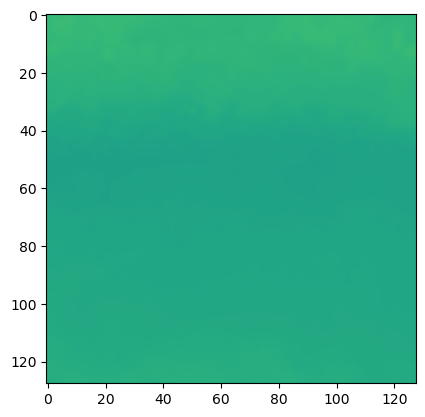

In [299]:
plt.imshow(x[0,], clim = (-3,3))

In [39]:
import time

c = 0
start_time = time.time()

for batch in data_loader:
    print(c)
    c += 1
    if c > 50:
        break

end_time = time.time()
print(f"Time elapsed: {end_time - start_time:.4f} seconds")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
Time elapsed: 36.0365 seconds


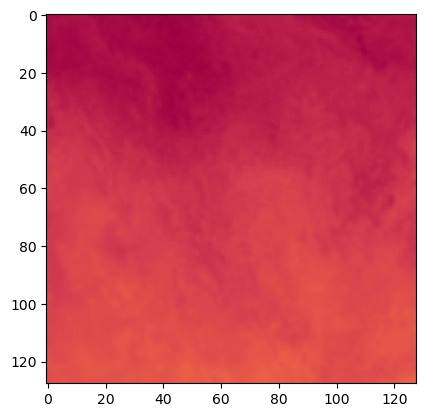

In [211]:
plt.imshow(sst[10,], cmap = 'Spectral_r', vmin=273)

In [9]:
xr.open_zarr()

AttributeError: module 'xarray' has no attribute 'open_zarr'

In [27]:
# !rm -r input_data/foo_bar2

In [13]:
class NeurOST_dataset(Dataset):
    def __init__(self, data_dir, mid_date, N_t, mean_ssh, std_ssh, mean_sst, std_sst, coord_grids, n = 128, L_x = 960e3, L_y = 960e3, filtered_sla = False, withheld_sats = None, sst_zarr_name = 'foo_bar', multiprocessing = True):
        self.data_dir = data_dir
        self.date = date
        self.N_t = N_t
        self.mean_ssh = mean_ssh
        self.std_ssh = std_ssh
        self.mean_sst = mean_sst
        self.std_sst = std_sst
        self.coord_grids = coord_grids
        self.n = n
        self.L_x = L_x
        self.L_y = L_y
        self.start_date = mid_date - timedelta(days=N_t/2)
        self.dates = [self.start_date + timedelta(days = t) for t in range(N_t)]
        ssh_files = GetListOfFiles(data_dir+'cmems_sla/')
        self.ssh_files = [f for f in ssh_files if date(int(f[-20:-16]),int(f[-16:-14]),int(f[-14:-12])) in self.dates]
        self.max_outvar_length = 400
        self.filtered_sla = filtered_sla
        self.withheld_sats = withheld_sats
        self.sst_zarr_name = sst_zarr_name
        if not multiprocessing:
            self.worker_ds_sst = xr.open_dataset(self.data_dir + self.sst_zarr_name, engine='zarr')
            self.worker_ds_ssh =load_multisat_ssh(self.ssh_files)
        
    def __len__(self):
        return self.coord_grids.shape[0]
    
    def worker_init_fn(self, worker_id):
        self.worker_ds_sst = xr.open_dataset(self.data_dir + self.sst_zarr_name, engine='zarr')
        self.worker_ds_ssh =load_multisat_ssh(self.ssh_files)

    def __getitem__(self, idx):
        lon0 = 0.25*(self.coord_grids[idx,int(self.n/2)-1,int(self.n/2)-1,0]+self.coord_grids[idx,int(self.n/2)-1,int(self.n/2),0]+self.coord_grids[idx,int(self.n/2),int(self.n/2)-1,0]+self.coord_grids[idx,int(self.n/2),int(self.n/2),0])
        lat0 = 0.25*(self.coord_grids[idx,int(self.n/2)-1,int(self.n/2)-1,1]+self.coord_grids[idx,int(self.n/2)-1,int(self.n/2),1]+self.coord_grids[idx,int(self.n/2),int(self.n/2)-1,1]+self.coord_grids[idx,int(self.n/2),int(self.n/2),1])
        
        sst = grid_sst_hr(self.worker_ds_sst,self.N_t,self.n, self.L_x, self.L_y, lon0, lat0, self.coord_grids[idx,])

        sst[sst!=0] = (sst[sst!=0]-self.mean_sst)/self.std_sst

        tracks_in, tracks_out = extract_tracked(self.worker_ds_ssh, self.start_date, self.start_date+timedelta(days=self.N_t+2), self.L_x, self.L_y, lon0, lat0, transformer_ll2xyz, withhold_sats = ['s3a','s3b'])
        ssh_in = grid_ssh(tracks_in, self.n, self.N_t, self.L_x, self.L_y, self.start_date,self.filtered_sla)
        ssh_out = reformat_output_tracks(tracks_out, self.max_outvar_length, self.N_t, self.n, self.L_x, self.L_y, self.start_date, self.mean_ssh, self.std_ssh, self.filtered_sla)

        ssh_in[ssh_in!=0] = (ssh_in[ssh_in!=0]-self.mean_ssh)/self.std_ssh
        invar = torch.from_numpy(np.stack((sst, ssh_in), axis = 1).astype(np.float32))
        outvar = torch.from_numpy(ssh_out)
        
        return invar, outvar

In [6]:
n_cpus = 15
data_dir = 'input_data/'
mid_date = date(2023,1,16)
N_t = 30
#pre-computed global normalisation stats
mean_ssh = 0.074
std_ssh = 0.0986
mean_sst = 293.307
std_sst = 8.726
coord_grids = np.load('/dat1/smart1n/aviso-data/global training data/preds_refactored/coord_grids.npy')
batch_size = 10
# def worker_load_zarrs(worker_id):
#     ds_sst = xr.open_dataset('foo_bar',engine='zarr')
#     ds_ssh = xr.open_dataset('foo_bar2',engine='zarr')
#     return ds_sst, ds_ssh
dataset = NeurOST_dataset(data_dir, mid_date, N_t, mean_ssh, std_ssh, mean_sst, std_sst, coord_grids)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=n_cpus, worker_init_fn = dataset.worker_init_fn,persistent_workers=True)


In [7]:
for step, (x, y) in enumerate(data_loader):
    print(step)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

IndexError: Caught IndexError in DataLoader worker process 3.
Original Traceback (most recent call last):
  File "/dat1/smart1n/miniconda3/envs/neurost/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
           ^^^^^^^^^^^^^^^^^^^^
  File "/dat1/smart1n/miniconda3/envs/neurost/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/dat1/smart1n/miniconda3/envs/neurost/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/dat1/smart1n/NeurOST/src/dataloaders.py", line 83, in __getitem__
    ssh_in = grid_ssh(tracks_in, self.n, self.N_t, self.L_x, self.L_y, self.start_date,self.filtered_sla)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/dat1/smart1n/NeurOST/src/interp_utils.py", line 251, in grid_ssh
    ssh_loop = ssh[first_indices[day-missed_days]:first_indices[day-missed_days+1]]
                                                  ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^
IndexError: list index out of range


In [8]:
data_loader._iterator. _shutdown_workers() 

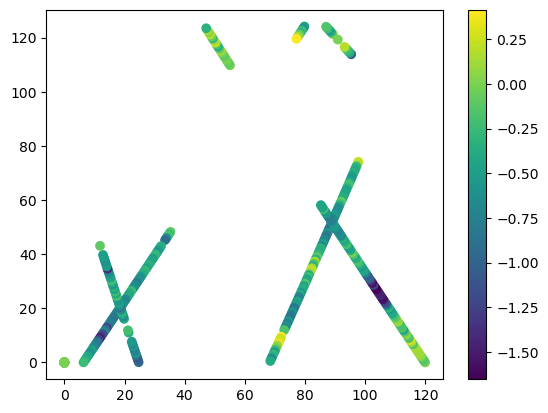

In [23]:
plt.scatter(y[0,0,:,0],y[0,0,:,1],c=y[0,0,:,2])
plt.colorbar()

In [8]:
x.shape

torch.Size([10, 30, 2, 128, 128])

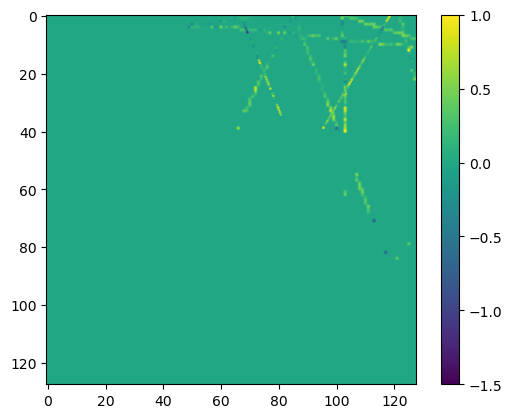

In [41]:
batch = 9
time = 10
plt.imshow(x[batch,time,1,:,:],vmin=-1.5,vmax=1)
plt.scatter(y[batch,time,:,0],y[batch,time,:,1],c=y[batch,time,:,2],s=1,vmin=-1.5,vmax=1)
plt.colorbar()

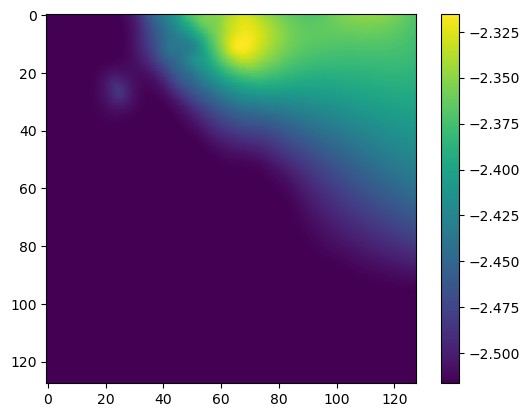

In [42]:
plt.imshow(x[batch,time,0,:,:])
plt.colorbar()

In [41]:
data_loader._iterator._shutdown_workers()

In [3]:
def load_multisat_ssh_dev(ssh_files):
    datasets = []
    ds = xr.open_dataset(ssh_files[0])
    sat = str(os.path.dirname(ssh_files[0]).split('cmems_sla/')[1])
    ds['time_variable'] = ds['time']
    ds['time'] = np.arange(ds['time'].shape[0])
    ds['sat'] = xr.DataArray([sat] * ds['time'].shape[0], dims=['time'])    
    ds = ds.rename({'time':'n_obs'})
    ds = ds.rename({'time_variable':'time'})
    datasets.append(ds)
    length = ds['n_obs'].shape[0]
    for f in ssh_files[1:]:
        ds = xr.open_dataset(f)
        sat = str(os.path.dirname(f).split('cmems_sla/')[1])
        ds['time_variable'] = ds['time']
        ds['time'] = np.arange(length,length+ds['time'].shape[0])
        ds['sat'] = xr.DataArray([sat] * ds['time'].shape[0], dims=['time'])
        ds = ds.rename({'time':'n_obs'})
        ds = ds.rename({'time_variable':'time'})
        datasets.append(ds)
        length+=ds['n_obs'].shape[0]
        # ds = xr.concat([ds,ds2],dim='n_obs')
    ds = xr.concat(datasets,dim='n_obs')
    ds = ds.sortby('time')
    ds['n_obs'] = ds['time']
    ds = ds.drop_vars(['time'])
    ds = ds.rename({'n_obs':'time'})
    
    return ds

In [25]:
import os

path = './input_data/cmems_sla/al/nrt_global_al_phy_l3_1hz_20230103_20230124.nc'
directory_name = os.path.dirname(path).split('cmems_sla/')[1]
print(directory_name)


al


In [2]:
data_dir = './input_data/'
start_date = date(2023,1,1)
N_t = 30
dates = [start_date + timedelta(days = t) for t in range(N_t)]
ssh_files = GetListOfFiles(data_dir+'cmems_sla/')
ssh_files = [f for f in ssh_files if date(int(f[-20:-16]),int(f[-16:-14]),int(f[-14:-12])) in dates]
ds = load_multisat_ssh(ssh_files)
print(ds)

<xarray.Dataset>
Dimensions:         (time: 10068077)
Coordinates:
  * time            (time) datetime64[ns] 2023-01-01T00:00:00.046843648 ... 2...
    longitude       (time) float64 -19.34 151.6 -19.37 ... 140.3 -85.83 -119.7
    latitude        (time) float64 -50.55 10.3 -50.49 ... -48.45 -14.67 -28.53
Data variables:
    cycle           (time) int16 74 94 74 94 74 94 74 ... 75 112 75 82 75 112 82
    track           (time) int16 517 32 517 32 517 32 517 ... 5 602 30 602 5 30
    sla_filtered    (time) float32 0.15 0.147 0.171 0.149 ... 0.132 0.102 0.17
    sla_unfiltered  (time) float32 0.125 0.144 0.162 0.141 ... 0.114 0.089 0.175
    flag            (time) float32 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    dac             (time) float32 0.151 -0.009 0.15 ... 0.159 -0.004 -0.113
    ocean_tide      (time) float32 -0.116 0.118 -0.116 ... -0.201 0.009 0.012
    internal_tide   (time) float32 0.0 -0.001 0.0 0.001 ... 0.0 0.004 0.003
    lwe             (time) float32 0.003 -0.001

In [44]:
start_date = date(2023,1,1)
end_date = date(2023,1,10)
ds.sel(time=slice(start_date,end_date))['time'][-1]

<xarray.DataArray 'time' ()>
array('2023-01-09T23:59:59.559519488', dtype='datetime64[ns]')
Coordinates:
    time       datetime64[ns] 2023-01-09T23:59:59.559519488
    longitude  float64 -48.79
    latitude   float64 -38.33
Attributes:
    axis:           T
    long_name:      Time of measurement
    standard_name:  time

In [21]:
ds = ds.chunk({'time':10000})

In [22]:
ds.to_zarr('input_data/foo_bar2')

/dat1/smart1n/miniconda3/envs/neurost/lib/python3.11/site-packages/xarray/core/dataset.py:2152: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  return to_zarr(  # type: ignore[call-overload,misc]
/dat1/smart1n/miniconda3/envs/neurost/lib/python3.11/site-packages/xarray/core/dataset.py:2152: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  return to_zarr(  # type: ignore[call-overload,misc]


In [20]:
10068077/1000

10068.077

In [63]:
test = dataset.ds_sst.chunk({'lon':120,'lat':120})

In [6]:
dataset.ds_sst.to_zarr('foo_bar')

In [23]:
test = xr.open_dataset('input_data/foo_bar2',engine='zarr')
print(test)

<xarray.Dataset>
Dimensions:         (time: 10068077)
Coordinates:
    latitude        (time) float64 ...
    longitude       (time) float64 ...
  * time            (time) datetime64[ns] 2023-01-01T00:00:00.046843648 ... 2...
Data variables:
    cycle           (time) int16 ...
    dac             (time) float32 ...
    flag            (time) float32 ...
    internal_tide   (time) float32 ...
    lwe             (time) float32 ...
    mdt             (time) float32 ...
    ocean_tide      (time) float32 ...
    sat             (time) <U6 ...
    sla_filtered    (time) float32 ...
    sla_unfiltered  (time) float32 ...
    track           (time) int16 ...
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea Surface Height measured by altimeter...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    crea

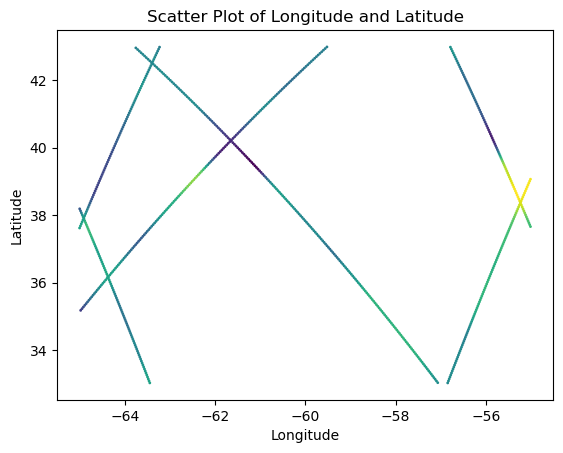

In [17]:

# Select the data for the 1st of January 2023

sla_data = test.sel(time='2023-01-03')
# Select data within latitude and longitude bounds
lat_min = 33
lat_max = 43
lon_min = -65
lon_max = -55

# Filter data based on latitude and longitude bounds
sla_data = sla_data.where((sla_data['latitude'] >= lat_min) & (sla_data['latitude'] <= lat_max) & (sla_data['longitude'] >= lon_min) & (sla_data['longitude'] <= lon_max), drop=True)

# Create a scatter plot with longitude and latitude
plt.scatter(sla_data['longitude'], sla_data['latitude'],c=sla_data['sla_filtered'], s=1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatter Plot of Longitude and Latitude')
plt.show()



In [41]:
coord_grid = np.load('/dat1/smart1n/aviso-data/global training data/preds_refactored/coord_grids.npy')
coord_grid.shape

(5615, 128, 128, 2)

In [55]:
idx = 985
lon_grid = coord_grid[idx,:,:,0]
n = 128
lon0 = 0.25*(coord_grid[idx,int(n/2)-1,int(n/2)-1,0]+coord_grid[idx,int(n/2)-1,int(n/2),0]+coord_grid[idx,int(n/2),int(n/2)-1,0]+coord_grid[idx,int(n/2),int(n/2),0])
print(lon0)
lat_grid = coord_grid[idx,:,:,1]

-178.47916666666669


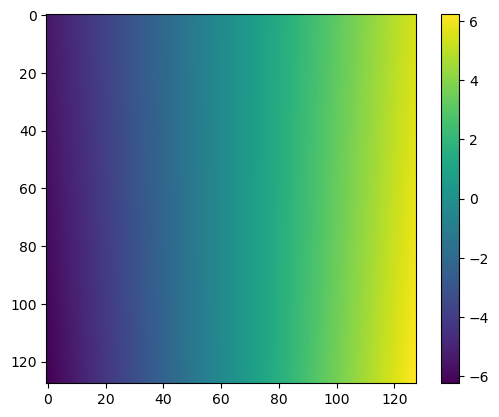

In [60]:
plt.imshow((lon_grid % 360 - lon0 + 180) % 360 - 180)
plt.colorbar()

In [ ]:
lon_grid = coord_grid[:,:,0].flatten()
lat_grid = coord_grid[:,:,1].flatten()
lat_max = np.max(lat_grid)+0.1
lat_min = np.min(lat_grid)-0.1


ds = ds.sel(lat=slice(lat_min,lat_max), drop = True)

if ((np.size(lon_grid[lon_grid>175])>0) and (np.size(lon_grid[lon_grid<-175])>0)):
    long_max_unshifted = np.max(lon_grid[lon_grid<0]) + 0.1
    long_min_unshifted = np.min(lon_grid[lon_grid>0]) - 0.1

else:
    long_max_unshifted = np.max(lon_grid) + 0.1
    long_min_unshifted = np.min(lon_grid) - 0.1

In [61]:
def extract_tracked_dev(ds, date_min, date_max, L_x, L_y, lon0, lat0, transformer_ll2xyz, coord_grid, withhold_sats=None):
    ds = ds.sel(time=slice(date_min, date_max))
    # shift to Greenwich to avoid dateline issues
    ds['longitude'] = (ds['longitude'] % 360 - lon0 + 180) % 360 - 180
    
    lon_grid = coord_grid[:,:,0].ravel()
    lat_grid = coord_grid[:,:,1].ravel()
    lat_max = np.max(lat_grid)+1
    lat_min = np.min(lat_grid)-1
    
    lon_grid_shifted = (lon_grid % 360 - lon0 + 180) % 360 - 180
    lon_max = np.max(lon_grid_shifted)+1
    lon_min = np.min(lon_grid_shifted)-1
    
    lon_mask = (ds['longitude'] >= lon_min) & (ds['longitude'] <= lon_max)
    lat_mask = (ds['latitude'] >= lat_min) & (ds['latitude'] <= lat_max)
    mask = lon_mask & lat_mask
    
    ds = ds.isel(time=mask)

    
    longitude = np.array(ds['longitude']).ravel() #(np.array(ds['longitude']) % 360 - lon0 + 180) % 360 - 180
    latitude = np.array(ds['latitude']).ravel()
    sla_f = np.array(ds['sla_filtered']).ravel()
    sla_uf = np.array(ds['sla_unfiltered']).ravel()
    sat = np.array(ds['sat']).ravel()
    t = np.array(ds['time']).ravel()

    x, y, z = ll2xyz(latitude, longitude, 0, lat0, 0, 0, transformer_ll2xyz)
    mask = (z > -1000e3) & (x < L_x / 2) & (x > -L_x / 2) & (y < L_y / 2) & (y > -L_y / 2)
    x, y, sla_f, sla_uf, sat, t = x[mask], y[mask], sla_f[mask], sla_uf[mask], sat[mask], t[mask]

    if withhold_sats is not None:
        mask = np.isin(sat, withhold_sats, invert=True)  
        x_in, y_in, t_in, sla_f_in, sla_uf_in = x[mask], y[mask], t[mask], sla_f[mask], sla_uf[mask]
        x_out, y_out, t_out, sla_f_out, sla_uf_out = x[~mask], y[~mask], t[~mask], sla_f[~mask], sla_uf[~mask]
        tracks_in = {'x': x_in, 'y': y_in, 'time': t_in, 'sla_filtered': sla_f_in, 'sla_unfiltered': sla_uf_in}
        tracks_out = {'x': x_out, 'y': y_out, 'time': t_out, 'sla_filtered': sla_f_out, 'sla_unfiltered': sla_uf_out}
        return tracks_in, tracks_out

    else:
        tracks = {'x': x, 'y': y, 'time': t, 'sla_filtered': sla_f, 'sla_unfiltered': sla_uf}
        return tracks

In [23]:
lon0 = -60
lat0 = 38
longitude = (np.array(ds['longitude']) % 360 - lon0 + 180) % 360 - 180
latitude = np.array(ds['latitude']).ravel()
sla_f = np.array(ds['sla_filtered']).ravel()
sla_uf = np.array(ds['sla_unfiltered']).ravel()
sat = np.array(ds['sat']).ravel()
t = np.array(ds['time']).ravel()

In [27]:
# convert lat, lon to ECEF coords
def ll2xyz_dev(lat, lon, alt, lat_org, lon_org, alt_org, transformer):

    # transform geodetic coords to ECEF (https://en.wikipedia.org/wiki/Earth-centered,_Earth-fixed_coordinate_system)
    x, y, z = transformer.transform( lon,lat, np.zeros_like(lon),radians=False)
    x_org, y_org, z_org = transformer.transform( lon_org,lat_org,  alt_org,radians=False)
    # define position of all points relative to origin of local tangent plane
    vec=np.array([[ x-x_org, y-y_org, z-z_org]]).T

    # define 3D rotation required to transform between ECEF and ENU coordinates (https://gssc.esa.int/navipedia/index.php/Transformations_between_ECEF_and_ENU_coordinates)
    rot1 =  scipy.spatial.transform.Rotation.from_euler('x', -(90-lat_org), degrees=True).as_matrix()
    rot3 =  scipy.spatial.transform.Rotation.from_euler('z', -(90+lon_org), degrees=True).as_matrix()
    rotMatrix = rot1.dot(rot3)    

    # rotate ECEF coordinates to ENU
    enu = rotMatrix.dot(vec).T
    X, Y, Z = enu[0, :, 0], enu[0, :, 1], enu[0, :, 2]
    # X = enu.T[0,:,0]
    # Y = enu.T[0,:,1]
    # Z = enu.T[0,:,2]
    return X, Y, Z

In [35]:
print(ds)

<xarray.Dataset>
Dimensions:         (time: 10068077)
Coordinates:
  * time            (time) datetime64[ns] 2023-01-01T00:00:00.046843648 ... 2...
    longitude       (time) float64 -19.34 151.6 -19.37 ... 140.3 -85.83 -119.7
    latitude        (time) float64 -50.55 10.3 -50.49 ... -48.45 -14.67 -28.53
Data variables:
    cycle           (time) int16 74 94 74 94 74 94 74 ... 75 112 75 82 75 112 82
    track           (time) int16 517 32 517 32 517 32 517 ... 5 602 30 602 5 30
    sla_filtered    (time) float32 0.15 0.147 0.171 0.149 ... 0.132 0.102 0.17
    sla_unfiltered  (time) float32 0.125 0.144 0.162 0.141 ... 0.114 0.089 0.175
    flag            (time) float32 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    dac             (time) float32 0.151 -0.009 0.15 ... 0.159 -0.004 -0.113
    ocean_tide      (time) float32 -0.116 0.118 -0.116 ... -0.201 0.009 0.012
    internal_tide   (time) float32 0.0 -0.001 0.0 0.001 ... 0.0 0.004 0.003
    lwe             (time) float32 0.003 -0.001

In [43]:
%%time
# Apply bounding box filter

min_lon = -65
max_lon = -55
min_lat = 33
max_lat = 43
lon_mask = (ds['longitude'] >= min_lon) & (ds['longitude'] <= max_lon)
lat_mask = (ds['latitude'] >= min_lat) & (ds['latitude'] <= max_lat)
mask = lon_mask & lat_mask

# # Subset the dataset
ds_subset = ds.isel(time=mask)
# ds_subset = ds.where((ds['latitude'] >= min_lat) & (ds['latitude'] <= max_lat) & (ds['longitude'] >= min_lon) & (ds['longitude'] <= max_lon), drop=True)
ds_subset

CPU times: user 129 ms, sys: 1.61 ms, total: 130 ms
Wall time: 129 ms


<xarray.Dataset>
Dimensions:         (time: 27894)
Coordinates:
  * time            (time) datetime64[ns] 2023-01-01T00:03:06.121384704 ... 2...
    longitude       (time) float64 -64.98 -64.94 -64.9 ... -59.96 -59.93 -59.9
    latitude        (time) float64 40.88 40.83 40.79 40.74 ... 33.15 33.09 33.04
Data variables:
    cycle           (time) int16 79 79 79 79 79 79 79 ... 82 82 82 82 82 82 82
    track           (time) int16 24 24 24 24 24 24 24 ... 24 24 24 24 24 24 24
    sla_filtered    (time) float32 0.032 0.028 0.024 0.022 ... 0.158 0.161 0.162
    sla_unfiltered  (time) float32 0.04 0.015 -0.005 0.024 ... 0.18 0.153 0.145
    flag            (time) float32 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    dac             (time) float32 -0.071 -0.073 -0.074 ... -0.143 -0.143 -0.143
    ocean_tide      (time) float32 -0.292 -0.292 -0.293 ... 0.068 0.068 0.068
    internal_tide   (time) float32 -0.003 -0.006 -0.007 ... -0.001 -0.001 0.0
    lwe             (time) float32 -0.025 -0.025 -0.024 ... -0.017 -0.017 -0.017
    mdt             (time) float32 -0.114 -0.111 -0.107 ... 0.577 0.575 0.574
    sat             (time) <U6 's6a-hr' 's6a-hr' 's6a-hr' ... 's6a-hr' 's6a-hr'
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea Surface Height measured by altimeter...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Near-Real-Time Level-3 sea ...
    time_coverage_duration:          P23H47M5.862293S
    time_coverage_end:               2023-01-03T23:47:06Z
    time_coverage_resolution:        P1S
    time_coverage_start:             2023-01-03T00:00:00Z
    title:                           NRT Altika Drifting Phase Global Ocean A...

In [28]:
%%prun
x, y, z = ll2xyz_dev(latitude, longitude, 0, lat0, 0, 0, transformer_ll2xyz)

         67 function calls (65 primitive calls) in 4.025 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    2.136    1.068    2.404    1.202 transformer.py:716(transform)
        2    1.087    0.544    1.087    0.544 {method 'dot' of 'numpy.ndarray' objects}
        3    0.268    0.089    0.268    0.089 {method 'astype' of 'numpy.ndarray' objects}
        1    0.201    0.201    3.941    3.941 3543306772.py:2(ll2xyz_dev)
        1    0.199    0.199    0.199    0.199 {built-in method numpy.array}
        1    0.084    0.084    4.024    4.024 <string>:1(<module>)
      3/1    0.049    0.016    0.049    0.049 {built-in method numpy.core._multiarray_umath.implement_array_function}
        2    0.000    0.000    0.000    0.000 {built-in method from_euler}
        1    0.000    0.000    4.025    4.025 {built-in method builtins.exec}
        3    0.000    0.000    0.268    0.089 utils.py:88(_copytobuffer)
        1    0.0

In [30]:
def extract_tracked(ds, date_min, date_max, L_x, L_y, lon0, lat0, transformer_ll2xyz, withhold_sats=None):
    ds = ds.sel(time=slice(date_min, date_max))

    longitude = (np.array(ds['longitude']) % 360 - lon0 + 180) % 360 - 180
    latitude = np.array(ds['latitude']).ravel()
    sla_f = np.array(ds['sla_filtered']).ravel()
    sla_uf = np.array(ds['sla_unfiltered']).ravel()
    sat = np.array(ds['sat']).ravel()
    t = np.array(ds['time']).ravel()

    x, y, z = ll2xyz(latitude, longitude, 0, lat0, 0, 0, transformer_ll2xyz)
    mask = (z > -1000e3) & (x < L_x / 2) & (x > -L_x / 2) & (y < L_y / 2) & (y > -L_y / 2)
    x, y, sla_f, sla_uf, sat, t = x[mask], y[mask], sla_f[mask], sla_uf[mask], sat[mask], t[mask]

    if withhold_sats is not None:
        mask = np.isin(sat, withhold_sats, invert=True)  
        x_in, y_in, t_in, sla_f_in, sla_uf_in = x[mask], y[mask], t[mask], sla_f[mask], sla_uf[mask]
        x_out, y_out, t_out, sla_f_out, sla_uf_out = x[~mask], y[~mask], t[~mask], sla_f[~mask], sla_uf[~mask]
        tracks_in = {'x': x_in, 'y': y_in, 'time': t_in, 'sla_filtered': sla_f_in, 'sla_unfiltered': sla_uf_in}
        tracks_out = {'x': x_out, 'y': y_out, 'time': t_out, 'sla_filtered': sla_f_out, 'sla_unfiltered': sla_uf_out}
        return tracks_in, tracks_out

    else:
        tracks = {'x': x, 'y': y, 'time': t, 'sla_filtered': sla_f, 'sla_unfiltered': sla_uf}
        return tracks


In [90]:
idx = 5200
n = 128
lon0 = 0.25*(coord_grid[idx,int(n/2)-1,int(n/2)-1,0]+coord_grid[idx,int(n/2)-1,int(n/2),0]+coord_grid[idx,int(n/2),int(n/2)-1,0]+coord_grid[idx,int(n/2),int(n/2),0])
lat0 = 0.25*(coord_grid[idx,int(n/2)-1,int(n/2)-1,1]+coord_grid[idx,int(n/2)-1,int(n/2),1]+coord_grid[idx,int(n/2),int(n/2)-1,1]+coord_grid[idx,int(n/2),int(n/2),1])

In [97]:
%%time
tracks_in, tracks_out = extract_tracked_dev(ds,'2023-01-01','2023-01-30', 960e3, 960e3, lon0, lat0, transformer_ll2xyz, coord_grid[idx,], ['s3b','s3a'])


CPU times: user 480 ms, sys: 213 ms, total: 693 ms
Wall time: 691 ms


In [98]:
%%time
in_grid = grid_ssh(tracks_in, 128,30, 960e3, 960e3, '2023-01-01')
out_grid = grid_ssh(tracks_out, 128,30, 960e3, 960e3, '2023-01-01')

CPU times: user 133 ms, sys: 820 µs, total: 134 ms
Wall time: 133 ms


In [66]:
in_grid.shape

(30, 128, 128)

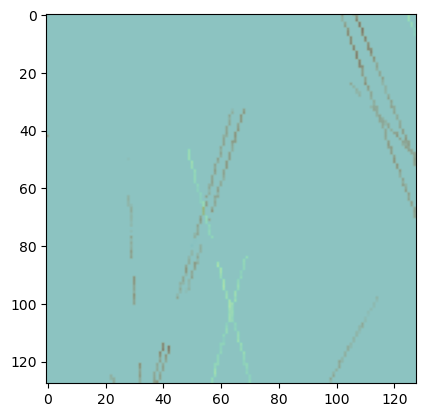

In [99]:
t = 15
plt.imshow(in_grid[t,],vmin=-0.5,vmax=0.5,cmap = 'RdBu_r')
plt.imshow(out_grid[t,],vmin=-0.5,vmax=0.5,cmap = 'viridis',alpha = 0.5)


In [12]:
start_date = np.datetime64('2023-01-01')
days_since_start = [dt - start_date for dt in tracks_in['time']]
days_since_start = (np.array(days_since_start).astype('timedelta64[D]') / np.timedelta64(1, 'D')).astype('int').tolist()
unique_values = np.unique(days_since_start)
first_indices = [np.where(days_since_start == value)[0][0] for value in unique_values]
n = 128
L_x = 960e3
L_y = 960e3
N_t = 30
data_final = np.zeros((n,n,N_t))
for t in range(N_t):
    if t == N_t-1:
        ssh = tracks_in['sla_unfiltered'][first_indices[t]:]
        x = tracks_in['x'][first_indices[t]:]
        y = tracks_in['y'][first_indices[t]:]
    else:
        ssh = tracks_in['sla_unfiltered'][first_indices[t]:first_indices[t+1]]
        x = tracks_in['x'][first_indices[t]:first_indices[t+1]]
        y = tracks_in['y'][first_indices[t]:first_indices[t+1]]
    x = x[~np.isnan(ssh)]
    y = y[~np.isnan(ssh)]
    ssh = ssh[~np.isnan(ssh)]
    input_grid, _,_,_ = stats.binned_statistic_2d(x, y, ssh, statistic = 'mean', bins=n, range = [[-L_x/2, L_x/2],[-L_y/2, L_y/2]])
    input_grid = np.rot90(input_grid)
    input_grid[np.isnan(input_grid)] = 0
    data_final[:,:,t] = input_grid


In [13]:
start_date = np.datetime64('2023-01-01')
days_since_start = [dt - start_date for dt in tracks_out['time']]
days_since_start = (np.array(days_since_start).astype('timedelta64[D]') / np.timedelta64(1, 'D')).astype('int').tolist()
unique_values = np.unique(days_since_start)
first_indices = [np.where(days_since_start == value)[0][0] for value in unique_values]
n = 128
L_x = 960e3
L_y = 960e3
N_t = 30
data_final_out = np.zeros((n,n,N_t))
for t in range(N_t):
    if t == N_t-1:
        ssh = tracks_out['sla_unfiltered'][first_indices[t]:]
        x = tracks_out['x'][first_indices[t]:]
        y = tracks_out['y'][first_indices[t]:]
    else:
        ssh = tracks_out['sla_unfiltered'][first_indices[t]:first_indices[t+1]]
        x = tracks_out['x'][first_indices[t]:first_indices[t+1]]
        y = tracks_out['y'][first_indices[t]:first_indices[t+1]]
    x = x[~np.isnan(ssh)]
    y = y[~np.isnan(ssh)]
    ssh = ssh[~np.isnan(ssh)]
    input_grid, _,_,_ = stats.binned_statistic_2d(x, y, ssh, statistic = 'mean', bins=n, range = [[-L_x/2, L_x/2],[-L_y/2, L_y/2]])
    input_grid = np.rot90(input_grid)
    input_grid[np.isnan(input_grid)] = 0
    data_final_out[:,:,t] = input_grid


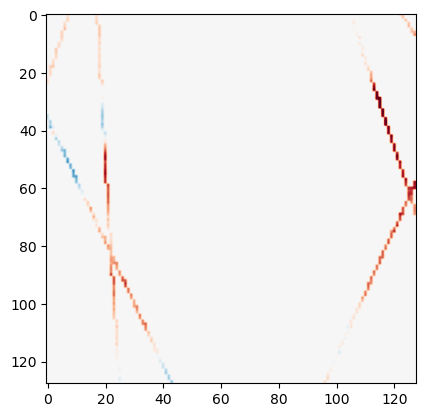

In [23]:
plt.imshow(data_final[:,:,21],vmin=-0.5,vmax=0.5,cmap='RdBu_r')

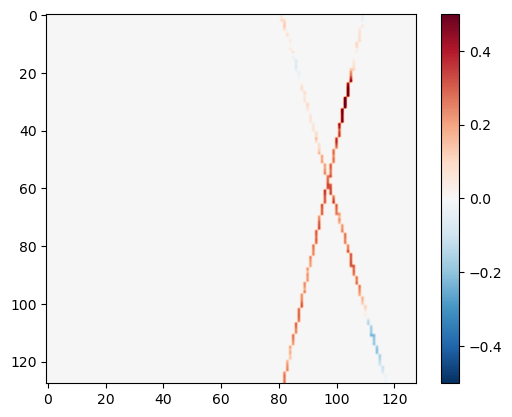

In [22]:
plt.imshow(data_final_out[:,:,21],vmin=-0.5,vmax=0.5,cmap='RdBu_r')
plt.colorbar()

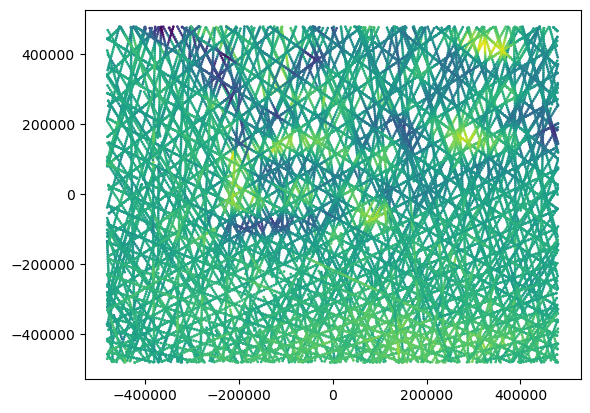

In [15]:
plt.scatter(tracks[:,0],tracks[:,1],c=tracks[:,2],s=1)

In [3]:
ds_sst = xr.open_zarr('input_data/foo_bar')
print(ds_sst)

<xarray.Dataset>
Dimensions:       (time: 30, lat: 3599, lon: 7200)
Coordinates:
  * lat           (lat) float32 -89.97 -89.92 -89.87 ... 89.83 89.88 89.93
  * lon           (lon) float32 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * time          (time) datetime64[ns] 2023-01-01T09:00:00 ... 2023-01-30T09...
Data variables:
    analysed_sst  (time, lat, lon) float32 dask.array<chunksize=(1, 3599, 1799), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.7
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    comment:                    MUR = "Multi-scale Ultra-high Resolution"
    creator_email:              ghrsst@podaac.jpl.nasa.gov
    ...                         ...
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    time_coverage_end:          20230101T210000Z
    time_coverage_start:        2

In [114]:
!du -sh foo_bar

608M	foo_bar


In [5]:
coord_grids = np.load('/dat1/smart1n/aviso-data/global training data/preds_refactored/coord_grids.npy')

In [6]:
%%time
idx = 4902
N_t = 30
n = 128
L_x = 960e3
L_y = 960e3
lon0 = 0.25*(coord_grids[idx,int(n/2)-1,int(n/2)-1,0]+coord_grids[idx,int(n/2)-1,int(n/2),0]+coord_grids[idx,int(n/2),int(n/2)-1,0]+coord_grids[idx,int(n/2),int(n/2),0])
lat0 = 0.25*(coord_grids[idx,int(n/2)-1,int(n/2)-1,1]+coord_grids[idx,int(n/2)-1,int(n/2),1]+coord_grids[idx,int(n/2),int(n/2)-1,1]+coord_grids[idx,int(n/2),int(n/2),1])
sst_grid = grid_sst_hr(ds_sst,N_t,n, L_x, L_y, lon0, lat0, coord_grids[idx,])

CPU times: user 2.06 s, sys: 5.3 s, total: 7.37 s
Wall time: 725 ms


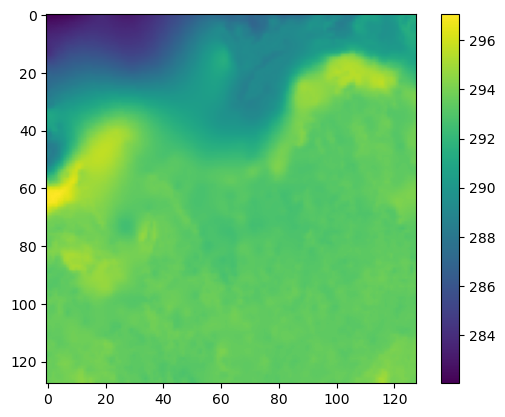

In [7]:
plt.imshow(sst_grid[15,])
plt.colorbar()

In [30]:
data_loader

In [4]:
test = da.from_zarr('foo_bar/analysed_sst')


NameError: name 'da' is not defined

CPU times: user 153 ms, sys: 19.3 ms, total: 172 ms
Wall time: 146 ms


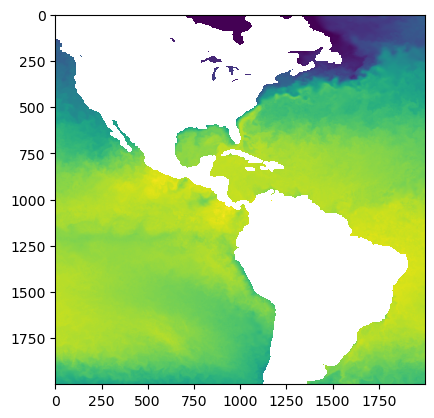

In [21]:
%%time
plt.imshow(np.flipud(dataset.ds_sst['analysed_sst'][-1,1000:3000,1000:3000]))

In [35]:
dataset.ds_sst

<xarray.Dataset> Size: 6GB
Dimensions:       (time: 30, lat: 3599, lon: 7200)
Coordinates:
  * time          (time) datetime64[ns] 240B 2023-01-01T09:00:00 ... 2023-01-...
  * lat           (lat) float32 14kB -89.97 -89.92 -89.87 ... 89.83 89.88 89.93
  * lon           (lon) float32 29kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Data variables:
    analysed_sst  (time, lat, lon) float64 6GB dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.7
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    ...                         ...
    project:                    NASA Making Earth Science Data Records for Us...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

In [18]:
!du -sh foo_bar

605M	foo_bar


CPU times: user 357 ms, sys: 109 ms, total: 466 ms
Wall time: 205 ms


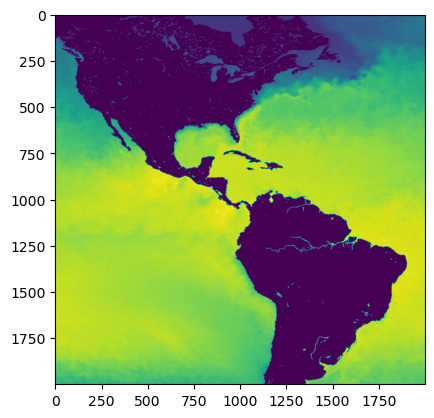

In [173]:
%%time
plt.imshow(np.flipud(test[-1,1000:3000,1000:3000]))

In [98]:
def grid_sst_hr_dev(data_sst_hr, n_t, n, L_x, L_y, lon0, lat0, coord_grid):
    ds = data_sst_hr#.copy()
    
    lon_grid = coord_grid[:,:,0].flatten()
    lat_grid = coord_grid[:,:,1].flatten()
    lat_max = np.max(lat_grid)
    lat_min = np.min(lat_grid)

    
    ds = ds.sel(lat=slice(lat_min,lat_max), drop = True)
    
    if ((np.size(lon_grid[lon_grid>175])>0) and (np.size(lon_grid[lon_grid<-175])>0)):
        long_max_unshifted = np.max(lon_grid[lon_grid<0])
        long_min_unshifted = np.min(lon_grid[lon_grid>0])
        
    else:
        long_max_unshifted = np.max(lon_grid)
        long_min_unshifted = np.min(lon_grid)
 
    if long_max_unshifted>long_min_unshifted:
        ds = ds.isel(lon = (ds.lon < long_max_unshifted) & (ds.lon > long_min_unshifted),drop = True)
    else:
        ds1 = ds.isel(lon = (ds.lon < long_max_unshifted),drop=True)
        ds2 = ds.isel(lon = (ds.lon > long_min_unshifted),drop=True)
        ds = xr.concat([ds1,ds2],'lon')
        # ds = ds.isel(lon = (ds.lon < long_max_unshifted) | (ds.lon > long_min_unshifted),drop = True)
    ds = ds.coarsen({'lon':5,'lat':5},boundary='trim').mean()
    ds = ds.load()

    ds['lon'] = (ds['lon']-lon0+180)%360-180

    lon = np.array(ds['lon'])
    lat = np.array(ds['lat'])
    lon, lat = np.meshgrid(lon, lat)

    lon = lon.flatten()
    lat = lat.flatten()
    
    sst_list = []
    for t in range(n_t):
        sst = np.array(ds['analysed_sst'].isel(time=t)).ravel()
        sst[np.isnan(sst)] = 0
        sst_list.append(sst)
    
    
    sst = np.array(ds['analysed_sst']).ravel()
    sst[np.isnan(sst)] = 0
        # sst_list.append(sst)
    # calculate ENU coords of data on tangent plane
    x,y,_ = ll2xyz(lat, lon, 0, lat0, 0, 0, transformer_ll2xyz)
    sst_grids, _,_,_ = stats.binned_statistic_2d(x, y, sst_list, statistic = 'mean', bins=n, range = [[-L_x/2, L_x/2],[-L_y/2, L_y/2]])
    for i,sst_grid in enumerate(sst_grids):
        sst_grid = np.rot90(sst_grid)
        sst_grid[sst_grid<270] = 0
        sst_grids[i] = sst_grid
    
    return sst_grids

In [87]:
!find foo_bar -type f | wc -l

3164


In [77]:
!find foo_bar2 -type f | wc -l

12177


In [5]:
%%time
start = 5000
size = 2000
ds = xr.open_dataset('foo_bar',engine='zarr')
# ds['analysed_sst'][0,start:start+size,start:start+size].plot()
ds

AttributeError: module 'xarray' has no attribute 'open_dataset'

In [31]:
%%time
n_cpus = 0
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=n_cpus, worker_init_fn = dataset.worker_init_fn)
# invars = []
for step, (x, y) in enumerate(data_loader):
    print(step)
    # invars.append(torch_input_batch)

AttributeError: 'NeurOST_dataset' object has no attribute 'worker_ds_sst'

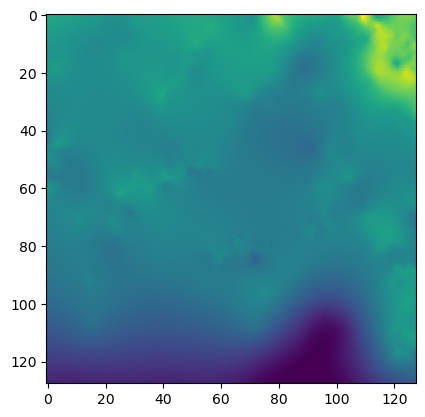

In [30]:
plt.imshow(invars[8][8,15,0,])

In [66]:
!du -sh foo_bar

771M	foo_bar


In [18]:
dataset.ds_sst.copy()

<xarray.Dataset> Size: 6GB
Dimensions:       (time: 30, lat: 3599, lon: 7200)
Coordinates:
  * time          (time) datetime64[ns] 240B 2023-01-01T09:00:00 ... 2023-01-...
  * lat           (lat) float32 14kB -89.97 -89.92 -89.87 ... 89.83 89.88 89.93
  * lon           (lon) float32 29kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Data variables:
    analysed_sst  (time, lat, lon) float64 6GB dask.array<chunksize=(30, 120, 120), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.7
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    ...                         ...
    project:                    NASA Making Earth Science Data Records for Us...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

In [11]:
print(torch.utils.data.get_worker_info())

None


In [120]:
n_cpus = 1
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=n_cpus)
invars = []
for torch_input_batch, _ in data_loader:
    print(torch_input_batch.shape)
    invars.append(torch_input_batch)

<xarray.Dataset> Size: 6GB
Dimensions:       (time: 30, lat: 3599, lon: 7200)
Coordinates:
  * time          (time) datetime64[ns] 240B 2023-01-01T09:00:00 ... 2023-01-...
  * lat           (lat) float32 14kB -89.97 -89.92 -89.87 ... 89.83 89.88 89.93
  * lon           (lon) float32 29kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Data variables:
    analysed_sst  (time, lat, lon) float64 6GB dask.array<chunksize=(30, 120, 120), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.7
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    ...                         ...
    project:                    NASA Making Earth Science Data Records for Us...
    publisher

KeyboardInterrupt: 

In [12]:
dataset.ds_sst

<xarray.Dataset> Size: 6GB
Dimensions:       (time: 30, lat: 3599, lon: 7200)
Coordinates:
  * time          (time) datetime64[ns] 240B 2023-01-01T09:00:00 ... 2023-01-...
  * lat           (lat) float32 14kB -89.97 -89.92 -89.87 ... 89.83 89.88 89.93
  * lon           (lon) float32 29kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Data variables:
    analysed_sst  (time, lat, lon) float64 6GB dask.array<chunksize=(30, 120, 120), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.7
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    ...                         ...
    project:                    NASA Making Earth Science Data Records for Us...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

In [9]:
dataset.ds_sst

<xarray.Dataset> Size: 6GB
Dimensions:       (time: 30, lat: 3599, lon: 7200)
Coordinates:
  * time          (time) datetime64[ns] 240B 2023-01-01T09:00:00 ... 2023-01-...
  * lat           (lat) float32 14kB -89.97 -89.92 -89.87 ... 89.83 89.88 89.93
  * lon           (lon) float32 29kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Data variables:
    analysed_sst  (time, lat, lon) float64 6GB dask.array<chunksize=(1, 120, 120), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.7
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    ...                         ...
    project:                    NASA Making Earth Science Data Records for Us...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

In [48]:
n_cpus = 0
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=n_cpus)

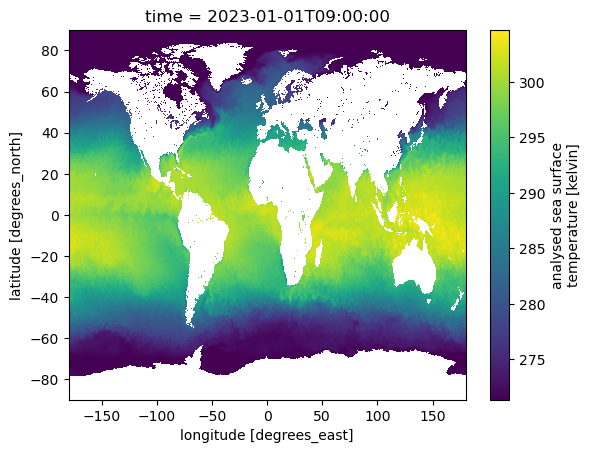

In [22]:
dataset.ds_sst.isel(time=0)['analysed_sst'].plot()

In [10]:
ds_sst = xr.open_dataset('input_data/foo_bar', engine = 'zarr')

In [172]:
def grid_ssh_dev(tracks, n, N_t, L_x, L_y, start_date, filtered=False):
    x = tracks['x']
    y = tracks['y']
    ssh = tracks['sla_filtered'] if filtered else tracks['sla_unfiltered']

    # Efficient Date Calculations with NumPy
    days_since_start = (tracks['time'] - np.datetime64(start_date)) / np.timedelta64(1, 'D')
    days_since_start = days_since_start.astype(int)
    
    # Group data by day and filter out NaN values.
    groups = [
        (x[days_since_start == day], y[days_since_start == day], ssh[days_since_start == day]) 
        for day in range(N_t)
    ]

    # Create a boolean mask that shows us which groups are empty.
    empty_mask = [len(group[0]) == 0 for group in groups]

    # Create an empty 3D array.
    data_final = np.zeros((N_t, n, n))
    
    # Replace empty groups with NaN values.
    valid_groups = [
        group if not empty else (np.zeros(1), np.zeros(1), np.zeros(1)) 
        for group, empty in zip(groups, empty_mask)
    ]

    # Create a list comprehension to calculate the statistic for each group.
    input_grids = [
        np.rot90(stats.binned_statistic_2d(x, y, ssh, statistic='mean', bins=n, range=[[-L_x/2, L_x/2], [-L_y/2, L_y/2]])[0])
        for x, y, ssh in valid_groups
    ]

    # Update the empty rows in `data_final` with 0
    data_final[empty_mask] = 0
    
    # Use np.stack and assign the result to a slice to get rid of nested loops.
    # if np.array(empty_mask)
    if np.sum(~np.array(empty_mask))>0:
        data_final[~np.array(empty_mask)] = np.stack(input_grids, axis=0)
    else:
        data_final = np.zeros((N_t, n, n))
        
    data_final[np.isnan(data_final)] = 0

    return data_final


def grid_ssh2(tracks,n,N_t,L_x,L_y,start_date,filtered=False):
    x = tracks['x']
    y = tracks['y']
    t = tracks['time']
    ssh = tracks['sla_filtered'] if filtered else tracks['sla_unfiltered']
    days_since_start = [dt - np.datetime64(start_date) for dt in tracks['time']]
    days_since_start = np.array((np.array(days_since_start).astype('timedelta64[D]') / np.timedelta64(1, 'D')).astype('int').tolist())
    unique_values = np.unique(days_since_start)
    missing_days = [t for t in range(N_t) if t not in unique_values]
    first_indices = [np.where(days_since_start == value)[0][0] for value in unique_values]
    data_final = np.zeros((N_t,n,n))
    missed_days = 0
    for day in range(N_t):
        if day not in missing_days:
            if day == N_t-1:
                ssh_loop = ssh[first_indices[day-missed_days]:]
                x_loop = x[first_indices[day-missed_days]:]
                y_loop = y[first_indices[day-missed_days]:]
            else:
                ssh_loop = ssh[first_indices[day-missed_days]:first_indices[day-missed_days+1]]
                x_loop = x[first_indices[day-missed_days]:first_indices[day-missed_days+1]]
                y_loop = y[first_indices[day-missed_days]:first_indices[day-missed_days+1]]

            x_loop = x_loop[~np.isnan(ssh_loop)]
            y_loop = y_loop[~np.isnan(ssh_loop)]
            ssh_loop = ssh_loop[~np.isnan(ssh_loop)]
        else:
            missed_days+=1
            x_loop = np.zeros(1)
            y_loop = np.zeros(1)
            ssh_loop = np.zeros(1)
        input_grid, _,_,_ = stats.binned_statistic_2d(x_loop, y_loop, ssh_loop, statistic = 'mean', bins=n, range = [[-L_x/2, L_x/2],[-L_y/2, L_y/2]])
        input_grid = np.rot90(input_grid)
        input_grid[np.isnan(input_grid)] = 0
        data_final[day,:,:] = input_grid

    return data_final

In [13]:
%%time
idx = 4902
n = 128
L_x = 960e3
L_y = 960e3
N_t = 30
lon0 = 0.25*(coord_grids[idx,int(n/2)-1,int(n/2)-1,0]+coord_grids[idx,int(n/2)-1,int(n/2),0]+coord_grids[idx,int(n/2),int(n/2)-1,0]+coord_grids[idx,int(n/2),int(n/2),0])
lat0 = 0.25*(coord_grids[idx,int(n/2)-1,int(n/2)-1,1]+coord_grids[idx,int(n/2)-1,int(n/2),1]+coord_grids[idx,int(n/2),int(n/2)-1,1]+coord_grids[idx,int(n/2),int(n/2),1])
sst_grid = grid_sst_hr(ds_sst, N_t, n, L_x, L_y, lon0, lat0, coord_grids[idx,])
tracks_in, tracks_out = extract_tracked(ds, date(2023,1,1), date(2023,1,31), L_x, L_y, lon0, lat0, transformer_ll2xyz, coord_grids[idx,],filtered=False, withhold_sats=['s3a'])
# ssh_in = grid_ssh(tracks_in,n,N_t,L_x,L_y,date(2023,1,1))
# ssh_in[np.isnan(ssh_in)] = 0
ssh_in = grid_ssh(tracks_in,n,N_t,L_x,L_y,date(2023,1,1))#,filtered=False)
# x_out_dev = reformat_output_tracks(tracks_out, 400, N_t, n, L_x, L_y, date(2023,1,1), 0.12, 0.07)#, filtered=False)
x_out = reformat_output_tracks(tracks_out, 400, N_t, n, L_x, L_y, date(2023,1,1), 0.12, 0.07)#, filtered=False)

# ssh_in_dev = grid_ssh2(tracks_in,n,N_t,L_x,L_y,date(2023,1,1),filtered=False)
# x_out = reformat_output_tracks(tracks_out, 400, N_t, n, L_x, L_y, date(2023,1,1), 0.12, 0.07, filtered=False)
# ssh_in_dev[np.isnan(ssh_in_dev)] = 0
# plt.pcolormesh(coord_grids[idx,:,:,0],coord_grids[idx,:,:,1],sst_grid[0,])
# plt.pcolormesh(coord_grids[idx,:,:,0],coord_grids[idx,:,:,1],ssh_in[0,],alpha=0.4,cmap='RdBu_r',vmin=-0.5,vmax=0.5)

KeyError: 'sla_unfiltered'

In [274]:
def reformat_output_tracks_dev(tracks, max_outvar_length, N_t, n, L_x, L_y, start_date, mean_ssh, std_ssh, filtered=False):
    x = tracks['x']
    y = tracks['y']
    ssh = tracks['sla_filtered'] if filtered else tracks['sla_unfiltered']

    # Efficiently calculate days since start using numpy
    days_since_start = (tracks['time'] - np.datetime64(start_date)) / np.timedelta64(1, 'D')
    days_since_start = days_since_start.astype(int)

    # Initialize the final data array
    data_final = np.zeros((N_t, max_outvar_length, 3))
    
    # Track which days have been processed to account for missing days
    processed_days = 0
    
    # Group data, filter, and transform in one step
    for day in range(N_t):
        mask = days_since_start == day
        x_loop = x[mask]
        y_loop = y[mask]
        ssh_loop = ssh[mask]
        
        # Remove NaN values (if any)
        valid_mask = ~np.isnan(ssh_loop)
        x_loop = x_loop[valid_mask]
        y_loop = y_loop[valid_mask]
        ssh_loop = ssh_loop[valid_mask]

        if x_loop.size > 0:  # Check if valid data exists for the day
            x_loop = rescale_x(x_loop, L_x, n)
            y_loop = rescale_y(y_loop, L_y, n)
            ssh_loop = normalise_ssh(ssh_loop, mean_ssh, std_ssh)

            # Store the data efficiently
            n_obs = min(x_loop.shape[0], max_outvar_length)
            data_final[processed_days, :n_obs, 0] = x_loop[:n_obs]
            data_final[processed_days, :n_obs, 1] = y_loop[:n_obs]
            data_final[processed_days, :n_obs, 2] = ssh_loop[:n_obs]

        # Only increment processed_days if valid data was found for the day
        if x_loop.size > 0:
            processed_days += 1

    return data_final

def reformat_output_tracks2(tracks, max_outvar_length, N_t, n, L_x, L_y, start_date, mean_ssh, std_ssh, filtered=False):
    x = tracks['x']
    y = tracks['y']
    ssh = tracks['sla_filtered'] if filtered else tracks['sla_unfiltered']

    # Efficiently calculate days since start using numpy
    days_since_start = (tracks['time'] - np.datetime64(start_date)) / np.timedelta64(1, 'D')
    days_since_start = days_since_start.astype(int)

    # Initialize the final data array
    data_final = np.zeros((N_t, max_outvar_length, 3))
    
    # Group data, filter, and transform in one step
    for day in range(N_t):
        mask = days_since_start == day
        x_loop = x[mask]
        y_loop = y[mask]
        ssh_loop = ssh[mask]
        print(day)
        print(x_loop.shape)
        # Remove NaN values (if any)
        valid_mask = ~np.isnan(ssh_loop)
        x_loop = x_loop[valid_mask]
        y_loop = y_loop[valid_mask]
        ssh_loop = ssh_loop[valid_mask]

        if x_loop.size > 0:  # Check if valid data exists for the day
            x_loop = rescale_x(x_loop, L_x, n)
            y_loop = rescale_y(y_loop, L_y, n)
            ssh_loop = normalise_ssh(ssh_loop, mean_ssh, std_ssh)

            # Store the data efficiently
            n_obs = min(x_loop.shape[0], max_outvar_length)
            data_final[day, :n_obs, 0] = x_loop[:n_obs]
            data_final[day, :n_obs, 1] = y_loop[:n_obs]
            data_final[day, :n_obs, 2] = ssh_loop[:n_obs]

    return data_final



In [243]:
%%time
# x_dev = reformat_output_tracks_dev(tracks_out, 400, N_t, n, L_x, L_y, date(2023,1,1), 0.12, 0.07, filtered=False)
x = reformat_output_tracks(tracks_out, 400, N_t, n, L_x, L_y, date(2023,1,1), 0.12, 0.07, filtered=False)
x.shape

CPU times: user 42.4 ms, sys: 153 µs, total: 42.6 ms
Wall time: 41 ms


(30, 400, 3)

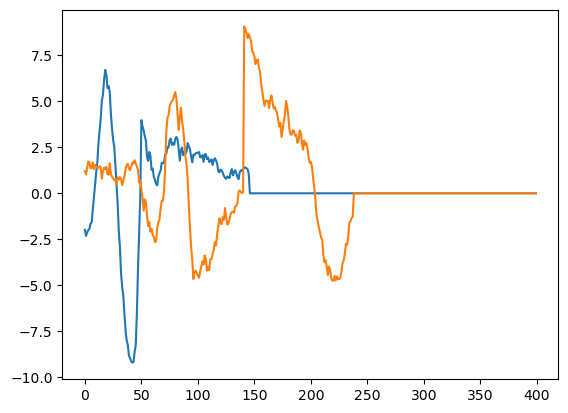

In [276]:
plt.plot(x_out[5,:,2])
plt.plot(x_out_dev[5,:,2])


In [266]:
print(x_out_dev[~np.equal(x_out,x_out_dev)].shape)
print(x_out[~np.equal(x_out,x_out_dev)].shape)


(0,)
(0,)


In [130]:
print(days_since_start[~np.equal(days_since_start,days_since_start_dev)])
print(days_since_start_dev[~np.equal(days_since_start,days_since_start_dev)])

[]
[]


In [131]:
print(ssh_in[~np.equal(ssh_in,ssh_in_dev)])
print(ssh_in_dev[~np.equal(ssh_in,ssh_in_dev)])

[0.22200002 0.26300001 0.171      0.149     ]
[0. 0. 0. 0.]


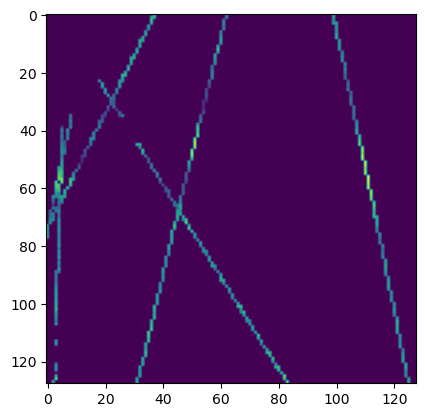

In [132]:
plt.imshow(ssh_in[0,])

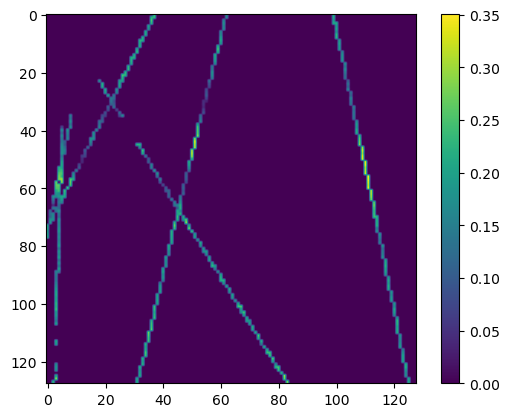

In [134]:
plt.imshow(ssh_in_dev[0,])
plt.colorbar()

In [40]:
ds = dataset.ds_sst

In [41]:
ds = ds.chunk({'lon':120,'lat':120})

In [42]:
ds

<xarray.Dataset> Size: 6GB
Dimensions:       (time: 30, lat: 3599, lon: 7200)
Coordinates:
  * time          (time) datetime64[ns] 240B 2023-01-01T09:00:00 ... 2023-01-...
  * lat           (lat) float32 14kB -89.97 -89.92 -89.87 ... 89.83 89.88 89.93
  * lon           (lon) float32 29kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Data variables:
    analysed_sst  (time, lat, lon) float64 6GB dask.array<chunksize=(30, 120, 120), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.7
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    ...                         ...
    project:                    NASA Making Earth Science Data Records for Us...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

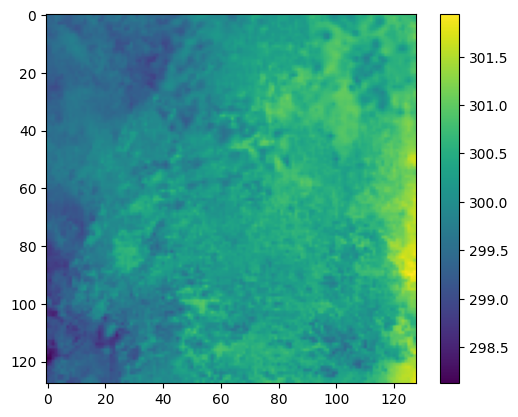

In [30]:
plt.imshow(invars[2][-1,15,:,:])
plt.colorbar()

In [3]:
ds_sst = xr.open_dataset('input_data/mur_sst/20230228090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc')
ds_sst
# ds_sst = ds_sst.coarsen({'lon':5,'lat':5},boundary='trim').mean()

<xarray.Dataset> Size: 29GB
Dimensions:           (time: 1, lat: 17999, lon: 36000)
Coordinates:
  * time              (time) datetime64[ns] 8B 2023-02-28T09:00:00
  * lat               (lat) float32 72kB -89.99 -89.98 -89.97 ... 89.98 89.99
  * lon               (lon) float32 144kB -180.0 -180.0 -180.0 ... 180.0 180.0
Data variables:
    analysed_sst      (time, lat, lon) float64 5GB ...
    analysis_error    (time, lat, lon) float64 5GB ...
    mask              (time, lat, lon) float32 3GB ...
    sea_ice_fraction  (time, lat, lon) float64 5GB ...
    dt_1km_data       (time, lat, lon) timedelta64[ns] 5GB ...
    sst_anomaly       (time, lat, lon) float64 5GB ...
Attributes: (12/47)
    Conventions:                CF-1.7
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    ...                         ...
    project:                    NASA Making Earth Science Data Records for Us...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

In [5]:
ds = ds_sst[['analysed_sst']]

In [16]:
def strided_coarsen(data, factor, dim_order='xy'):
    """
    Coarsens a DataArray by a factor using strided selection and averaging.

    Args:
      data (xr.DataArray): The data array to coarsen.
      factor (int): The coarsening factor (same for both lon and lat).
      dim_order (str, optional): The order of dimensions ('xy' or 'yx'). Defaults to 'xy'.

    Returns:
      xr.DataArray: The coarsened data array.
    """
    if factor < 1:
        raise ValueError("Coarsening factor must be greater than or equal to 1")

    if dim_order not in ['xy', 'yx']:
        raise ValueError("dim_order must be 'xy' or 'yx'")

    data_dims = list(data.dims)
    if dim_order == 'xy':
        lon_dim, lat_dim = data_dims
    else:
        lat_dim, lon_dim = data_dims

    # Calculate strides for lon and lat
    lon_stride, lat_stride = factor, factor
    print('initialising')
    # Create empty DataArray to store coarsened data
    coarsened_data = xr.DataArray(
      data=np.zeros(data[::lon_stride, ::lat_stride].shape),
      dims=data_dims,
      coords=data[::lon_stride, ::lat_stride].coords,
    )

    # Loop over all coarsening windows and average
    for i in range(0, data.sizes[lon_dim] - factor + 1, lon_stride):
        print(i)
        for j in range(0, data.sizes[lat_dim] - factor + 1, lat_stride):
            window = data.isel({lon_dim: slice(i, i + factor), lat_dim: slice(j, j + factor)})
            coarsened_data.loc[dict(zip(data_dims, [i // factor, j // factor]))] = window.mean(dim=[lon_dim, lat_dim])

    return coarsened_data

In [25]:
%%time
test = ds_sst['analysed_sst'].coarsen({'lon':2,'lat':2},boundary='trim').mean()

CPU times: user 17.9 s, sys: 12.6 s, total: 30.5 s
Wall time: 30.5 s


In [19]:
factor = 2
idx_lat00 = factor*np.arange(int(data.shape[1]/factor))
idx_lon00 = factor*np.arange(int(data.shape[2]/factor))
idx_lat01 = factor*np.arange(int(data.shape[1]/factor))+1
idx_lon01 = factor*np.arange(int(data.shape[2]/factor))
idx_lat10 = factor*np.arange(int(data.shape[1]/factor))
idx_lon10 = factor*np.arange(int(data.shape[2]/factor))+1
idx_lat11 = factor*np.arange(int(data.shape[1]/factor))+1
idx_lon11 = factor*np.arange(int(data.shape[2]/factor))+1


In [20]:
%%time
test00 = data[:,idx_lat00,:][:,:,idx_lon00]
test01 = data[:,idx_lat01,:][:,:,idx_lon01]
test10 = data[:,idx_lat10,:][:,:,idx_lon10]
test11 = data[:,idx_lat11,:][:,:,idx_lon11]

CPU times: user 15.7 s, sys: 14.6 s, total: 30.4 s
Wall time: 30.5 s


In [21]:
coarse = 0.25*(test00+test01+test10+test11)

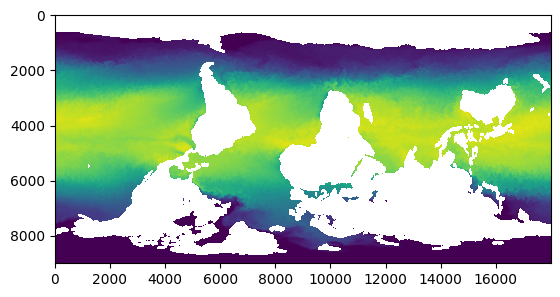

In [22]:
plt.imshow(coarse[0,:,:])

In [23]:
coarse.shape

(1, 8999, 18000)

In [5]:
ds_sst['analysed_sst'].values

KeyboardInterrupt: 

In [ ]:
!htop

In [17]:
strided_coarsen(ds['analysed_sst'].isel(time=0),2)

initialising
0


KeyError: "not all values found in index 'lat'. Try setting the `method` keyword argument (example: method='nearest')."

In [8]:
ds.coarsen({'lon':2,'lat':2},boundary = 'trim').mean()

<xarray.Dataset> Size: 1GB
Dimensions:       (time: 1, lat: 8999, lon: 18000)
Coordinates:
  * time          (time) datetime64[ns] 8B 2023-02-28T09:00:00
  * lat           (lat) float32 36kB -89.99 -89.96 -89.94 ... 89.93 89.96 89.98
  * lon           (lon) float32 72kB -180.0 -180.0 -179.9 ... 180.0 180.0 180.0
Data variables:
    analysed_sst  (time, lat, lon) float64 1GB nan nan nan ... 271.3 271.3 271.3
Attributes: (12/47)
    Conventions:                CF-1.7
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    ...                         ...
    project:                    NASA Making Earth Science Data Records for Us...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

In [36]:
idx = 606
n = 128
L_x = 960e3
L_y = 960e3
lon0 = 0.25*(coord_grids[idx,int(n/2)-1,int(n/2)-1,0]+coord_grids[idx,int(n/2)-1,int(n/2),0]+coord_grids[idx,int(n/2),int(n/2)-1,0]+coord_grids[idx,int(n/2),int(n/2),0])
lat0 = 0.25*(coord_grids[idx,int(n/2)-1,int(n/2)-1,1]+coord_grids[idx,int(n/2)-1,int(n/2),1]+coord_grids[idx,int(n/2),int(n/2)-1,1]+coord_grids[idx,int(n/2),int(n/2),1])

In [34]:
# bin average high res MUR L4 SST (MW+IR observations)
def grid_sst_hr_dev(data_sst_hr, n_t, n, L_x, L_y, lon0, lat0, coord_grid):
    ds = data_sst_hr
    
    lon_grid = coord_grid[:,:,0].flatten()
    lat_grid = coord_grid[:,:,1].flatten()
    lat_max = np.max(lat_grid)
    lat_min = np.min(lat_grid)

    
    ds = ds.sel(lat=slice(lat_min,lat_max), drop = True)
    
    if ((np.size(lon_grid[lon_grid>175])>0) and (np.size(lon_grid[lon_grid<-175])>0)):
        print('triggered')
        long_max_unshifted = np.max(lon_grid[lon_grid<0])
        long_min_unshifted = np.min(lon_grid[lon_grid>0])
        
    else:
        long_max_unshifted = np.max(lon_grid)
        long_min_unshifted = np.min(lon_grid)
 
    if long_max_unshifted>long_min_unshifted:
        # ds = ds.sel(lon=slice(long_min_unshifted,long_max_unshifted),drop=True)
        ds = ds.isel(lon = (ds.lon < long_max_unshifted) & (ds.lon > long_min_unshifted),drop = True)
    else:
        print('triggered')
        ds1 = ds.isel(lon = (ds.lon < long_max_unshifted),drop=True)#ds.sel(lon=slice(-180,long_max_unshifted),drop=True)
        ds2 = ds.isel(lon = (ds.lon > long_min_unshifted),drop=True)#ds.sel(lon=slice(long_min_unshifted,180))
        ds = xr.concat([ds1,ds2],'lon')
        # ds = ds.isel(lon = (ds.lon < long_max_unshifted) | (ds.lon > long_min_unshifted),drop = True)
    
    ds = ds.load()

    ds['lon'] = (ds['lon']-lon0+180)%360-180

    lon = np.array(ds['lon'])
    lat = np.array(ds['lat'])
    lon, lat = np.meshgrid(lon, lat)

    lon = lon.flatten()
    lat = lat.flatten()
    sst_list = []
    for t in range(n_t):
        sst = np.array(ds['analysed_sst'].isel(time=t)).ravel()
        sst[np.isnan(sst)] = 0
        sst_list.append(sst)
    # calculate ENU coords of data on tangent plane
    x,y,_ = ll2xyz(lat, lon, 0, lat0, 0, 0, transformer_ll2xyz)
    sst_grids, _,_,_ = stats.binned_statistic_2d(x, y, sst_list, statistic = 'mean', bins=n, range = [[-L_x/2, L_x/2],[-L_y/2, L_y/2]])
    for i,sst_grid in enumerate(sst_grids):
        sst_grid_rot = np.rot90(sst_grid)
        sst_grid_rot[sst_grid_rot<273] = 0
        sst_grids[i] = sst_grid_rot
    
    return sst_grids

In [6]:
# ds_sst = xr.open_dataset('input_data/mur_sst/20230101090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc')
ds_sst = xr.open_dataset('/dat1/smart1n/aviso-data/sst_high_res/20230226090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc')
ds_sst

<xarray.Dataset> Size: 29GB
Dimensions:           (time: 1, lat: 17999, lon: 36000)
Coordinates:
  * time              (time) datetime64[ns] 8B 2023-02-26T09:00:00
  * lat               (lat) float32 72kB -89.99 -89.98 -89.97 ... 89.98 89.99
  * lon               (lon) float32 144kB -180.0 -180.0 -180.0 ... 180.0 180.0
Data variables:
    analysed_sst      (time, lat, lon) float64 5GB ...
    analysis_error    (time, lat, lon) float64 5GB ...
    mask              (time, lat, lon) float32 3GB ...
    sea_ice_fraction  (time, lat, lon) float64 5GB ...
    dt_1km_data       (time, lat, lon) timedelta64[ns] 5GB ...
    sst_anomaly       (time, lat, lon) float64 5GB ...
Attributes: (12/47)
    Conventions:                CF-1.7
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    ...                         ...
    project:                    NASA Making Earth Science Data Records for Us...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

In [12]:
ds_sst

<xarray.Dataset> Size: 29GB
Dimensions:           (time: 1, lat: 17999, lon: 36000)
Coordinates:
  * time              (time) datetime64[ns] 8B 2023-02-28T09:00:00
  * lat               (lat) float32 72kB -89.99 -89.98 -89.97 ... 89.98 89.99
  * lon               (lon) float32 144kB -180.0 -180.0 -180.0 ... 180.0 180.0
Data variables:
    analysed_sst      (time, lat, lon) float64 5GB ...
    analysis_error    (time, lat, lon) float64 5GB ...
    mask              (time, lat, lon) float32 3GB ...
    sea_ice_fraction  (time, lat, lon) float64 5GB ...
    dt_1km_data       (time, lat, lon) timedelta64[ns] 5GB ...
    sst_anomaly       (time, lat, lon) float64 5GB ...
Attributes: (12/47)
    Conventions:                CF-1.7
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    ...                         ...
    project:                    NASA Making Earth Science Data Records for Us...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

In [37]:
%%time
sst_grid = grid_sst_hr_dev(ds_sst, 1, n, L_x, L_y, lon0, lat0, coord_grids[idx,])

CPU times: user 3.5 s, sys: 932 ms, total: 4.43 s
Wall time: 4.43 s


In [13]:
len(sst_grid)

1

In [ ]:
plt.pcolormesh(coord_grids[idx,:,:,0],coord_grids[idx,:,:,1],sst_grid[0])
plt.colorbar()

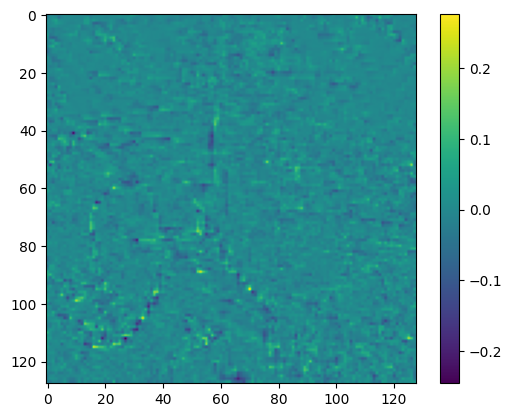

In [23]:
plt.imshow(sst_grid2[0]-sst_grid[0])
plt.colorbar()

In [16]:
def open_concat_sort(filepath):
    """
    This function opens a netcdf file, concatenates it along a new dimension, 
    and returns the sorted dataset.
    """
    dataset = xr.open_dataset(filepath)
    # Add a new dimension (e.g., 'file') with a value for this file
    dataset = dataset.expand_dims('file', [filepath.split('/')[-1]])
    return dataset.sortby('time')

In [41]:
ssh_dir = 'input_data/cmems_sla/'
sats = ['al','c2n','h2b','j3n','s3a','s3b','s6a-hr','swon']
dates = [date(2023,1,1),date(2023,1,2)]
ssh_files = GetListOfFiles(ssh_dir)
ssh_files = [f for f in ssh_files if date(int(f[-20:-16]),int(f[-16:-14]),int(f[-14:-12])) in dates]

ds = load_multisat_ssh(ssh_files)
ds = ds.sel(time=slice(np.datetime64('2023-01-01T00:00:00.046843648'),np.datetime64('2023-01-01T10:00:00.046843648')))
ds
# ds = xr.open_dataset(ssh_files[0])
# ds['time_variable'] = ds['time']
# ds['time'] = np.arange(ds['time'].shape[0])
# ds = ds.rename({'time':'n_obs'})
# ds = ds.rename({'time_variable':'time'})
# ds.sortby('time')
# ds2 = xr.open_dataset(ssh_files[1])
# ds2['time_variable'] = ds2['time']
# ds2['time'] = np.arange(ds['n_obs'].shape[0],ds['n_obs'].shape[0]+ds2['time'].shape[0])
# ds2 = ds2.rename({'time':'n_obs'})
# ds2 = ds2.rename({'time_variable':'time'})
# ds = xr.concat([ds,ds2],dim='n_obs')


<xarray.Dataset> Size: 12MB
Dimensions:         (time: 133697)
Coordinates:
  * time            (time) datetime64[ns] 1MB 2023-01-01T00:00:00.046843648 ....
    longitude       (time) float64 1MB -19.34 151.6 -19.37 ... -151.1 -151.1
    latitude        (time) float64 1MB -50.55 10.3 -50.49 ... -56.45 -56.49
Data variables:
    cycle           (time) int16 267kB 74 94 74 94 74 94 ... 79 79 79 79 79 79
    track           (time) int16 267kB 517 32 517 32 517 32 ... 34 34 34 34 34
    sla_filtered    (time) float64 1MB 0.15 0.147 0.171 ... 0.091 0.082 0.071
    sla_unfiltered  (time) float64 1MB 0.125 0.144 0.162 ... 0.084 0.089 0.112
    flag            (time) float32 535kB 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    dac             (time) float64 1MB 0.151 -0.009 0.15 ... 0.136 0.137 0.138
    ocean_tide      (time) float64 1MB -0.116 0.118 -0.116 ... 0.009 0.009 0.009
    internal_tide   (time) float64 1MB 0.0 -0.001 0.0 ... -0.001 -0.001 -0.001
    lwe             (time) float64 1MB 0.003 -0.001 0.002 ... 0.015 0.015 0.015
    mdt             (time) float64 1MB -0.722 1.027 -0.719 ... -0.798 -0.807
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea Surface Height measured by altimeter...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Near-Real-Time Level-3 sea ...
    time_coverage_duration:          P23H59M58.350569S
    time_coverage_end:               2023-01-02T23:59:59Z
    time_coverage_resolution:        P1S
    time_coverage_start:             2023-01-02T00:00:00Z
    title:                           NRT Altika Drifting Phase Global Ocean A...

In [8]:
dates = [date(2023,1,1),date(2023,1,2)]
mid_date = date(2023,1,16)
N_t = 30
start_date = mid_date - timedelta(days=N_t/2)
dates = [start_date + timedelta(days = t) for t in range(N_t)]
sst_dir = 'input_data/mur_sst/'
sst_files = os.listdir(sst_dir)
sst_files = [f for f in sst_files if '.nc' in f]
sst_files = [f for f in sst_files if date(int(f[:4]),int(f[4:6]),int(f[6:8])) in dates]
sst_paths = [sst_dir + f for f in sst_files]
ds_sst = xr.open_mfdataset(sorted(sst_paths))
ds_sst = ds_sst[['analysed_sst']]
n = 128
L_x = 960e3
L_y = 960e3
idx = 4902
lon0 = 0.25*(coord_grids[idx,int(n/2)-1,int(n/2)-1,0]+coord_grids[idx,int(n/2)-1,int(n/2),0]+coord_grids[idx,int(n/2),int(n/2)-1,0]+coord_grids[idx,int(n/2),int(n/2),0])
lat0 = 0.25*(coord_grids[idx,int(n/2)-1,int(n/2)-1,1]+coord_grids[idx,int(n/2)-1,int(n/2),1]+coord_grids[idx,int(n/2),int(n/2)-1,1]+coord_grids[idx,int(n/2),int(n/2),1])

# sorted(sst_files)
lat0

37.545833333333334

In [57]:
%%time
sst_grids = grid_sst_hr_dev(dataset.ds_sst, N_t, n, L_x, L_y, lon0, lat0, coord_grids[idx,])

NameError: name 'grid_sst_hr_dev' is not defined

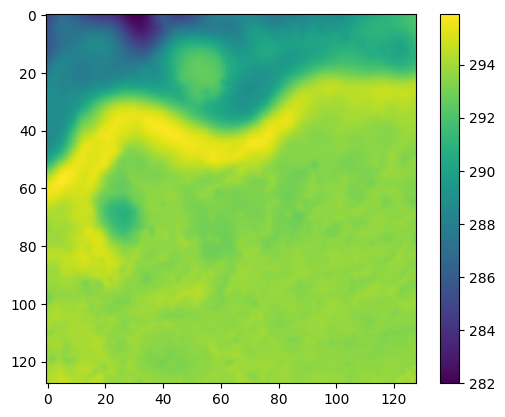

In [63]:
plt.imshow(sst_grids[10])
plt.colorbar()

In [37]:
test = xr.open_dataset('/dat1/smart1n/aviso-data/global training data/SimVP_SSH_SST_1M_global_L250km_mappedSLA_wgrads_20190101_20240330.nc')
test

<xarray.Dataset> Size: 302MB
Dimensions:    (latitude: 1500, longitude: 3600, time: 1)
Coordinates:
  * longitude  (longitude) float64 29kB 0.1 0.2 0.3 0.4 ... 359.8 359.9 360.0
  * latitude   (latitude) float64 12kB -70.0 -69.9 -69.8 ... 79.7 79.8 79.9
  * time       (time) datetime64[ns] 8B 2019-01-01
Data variables:
    sla        (latitude, longitude, time) float64 43MB ...
    adt        (latitude, longitude, time) float64 43MB ...
    dSLA_dx    (latitude, longitude, time) float64 43MB ...
    dSLA_dy    (latitude, longitude, time) float64 43MB ...
    d2SLA_dx2  (latitude, longitude, time) float64 43MB ...
    d2SLA_dy2  (latitude, longitude, time) float64 43MB ...
    d2SLA_dxy  (latitude, longitude, time) float64 43MB ...

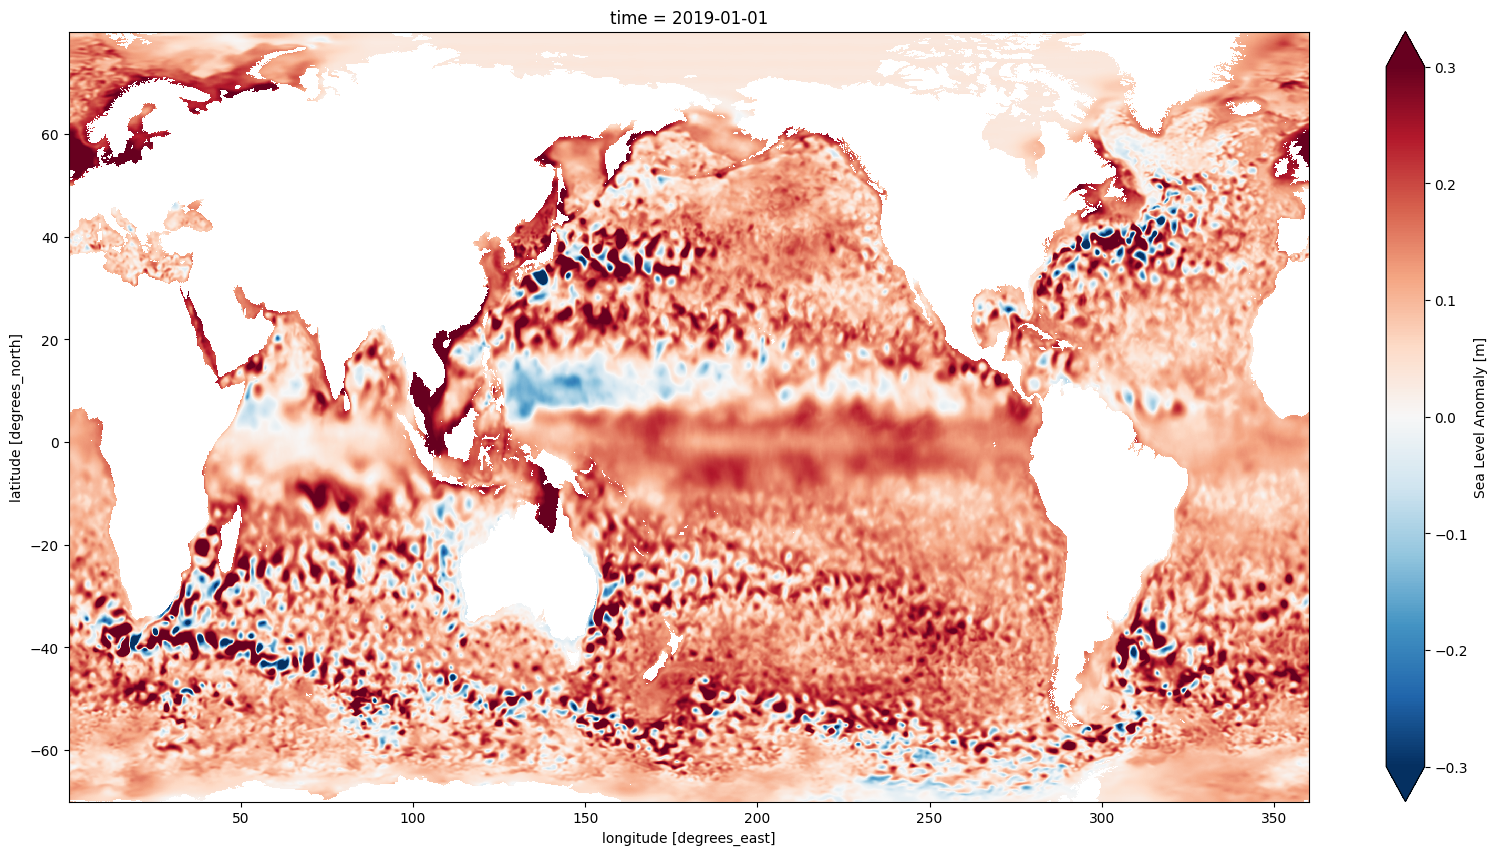

In [38]:
plt.figure(figsize=(20,10))
test['sla'].plot(cmap='RdBu_r',vmin=-0.3,vmax=0.3)

In [49]:
test2 = xr.open_dataset('/dat1/smart1n/aviso-data/global training data/2023a_SSH_mapping_OSE/data/maps/GLORYS/cmems_mod_glo_phy_my_0.083deg_P1D-m_uo-vo-zos_180.00W-179.92E_80.00S-90.00N_0.49m_2019-01-01.nc')
ds_mdt = xr.open_dataset('/dat1/smart1n/aviso-data/global training data/2023a_SSH_mapping_OSE/GLO-MFC_001_030_mdt.nc')
test2['sla'] = test2['zos']-ds_mdt['mdt']
test2['longitude'] = test2['longitude']%360
test2 = test2.sortby('longitude')

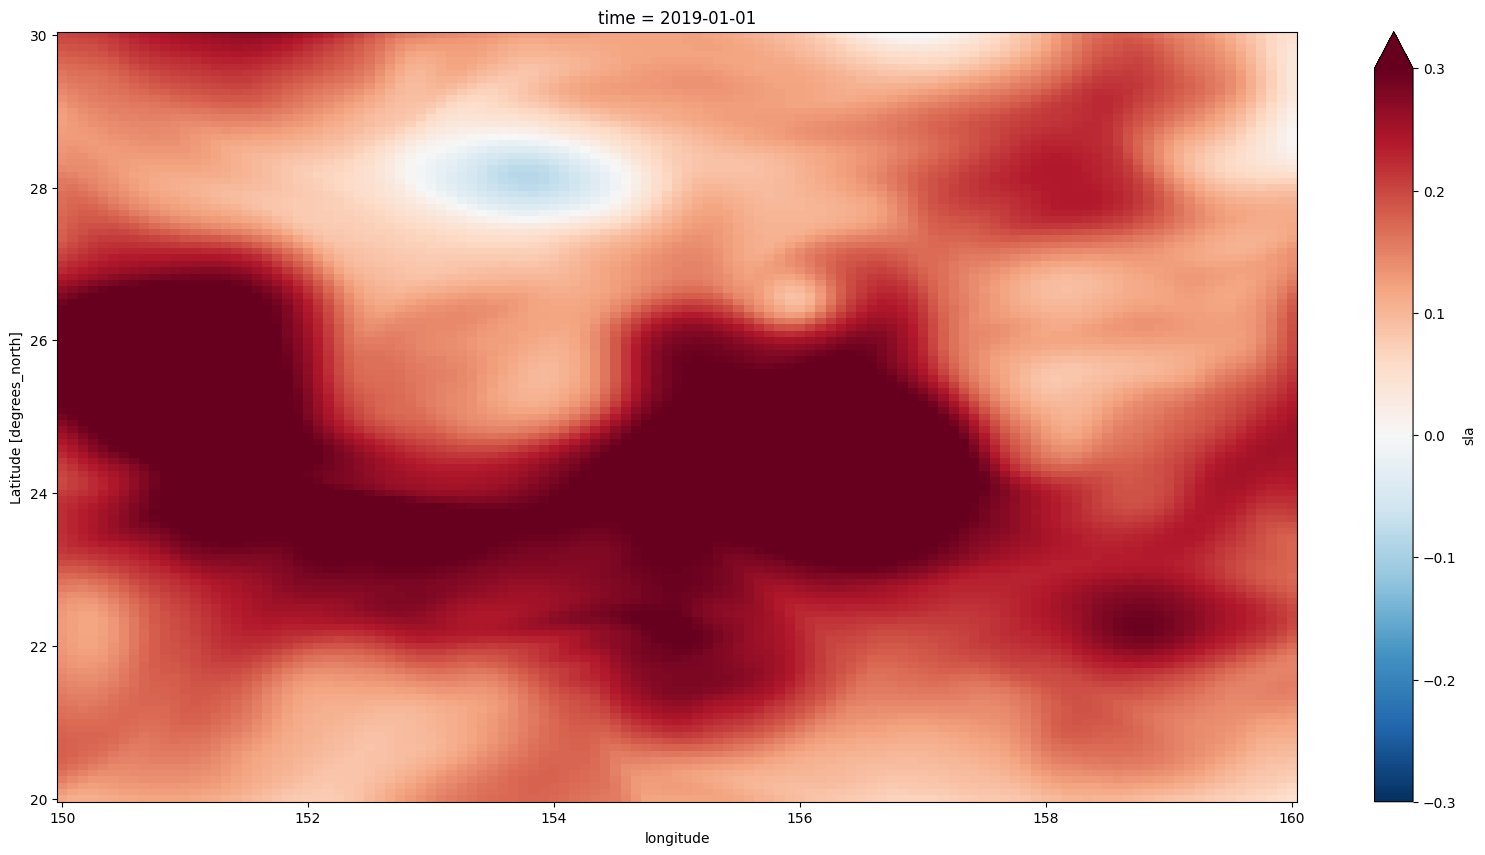

In [52]:
plt.figure(figsize=(20,10))
test2['sla'].sel(latitude=slice(20,30),longitude=slice(150,160)).plot(cmap='RdBu_r',vmin=-0.3,vmax=0.3)

In [42]:
test2 = test2.isel(depth=0,time=0).interp_like(test.isel(time=0))


<xarray.Dataset> Size: 130MB
Dimensions:    (latitude: 1500, longitude: 3600)
Coordinates:
    depth      float32 4B 0.494
    time       datetime64[ns] 8B 2019-01-01
  * latitude   (latitude) float64 12kB -70.0 -69.9 -69.8 ... 79.7 79.8 79.9
  * longitude  (longitude) float64 29kB 0.1 0.2 0.3 0.4 ... 359.8 359.9 360.0
Data variables:
    uo         (latitude, longitude) float64 43MB nan nan nan ... nan nan nan
    vo         (latitude, longitude) float64 43MB nan nan nan ... nan nan nan
    zos        (latitude, longitude) float64 43MB nan nan nan ... nan nan nan
Attributes: (12/25)
    Conventions:               CF-1.4
    bulletin_date:             2021-07-07 00:00:00
    bulletin_type:             operational
    comment:                   CMEMS product
    domain_name:               GL12
    easting:                   longitude
    ...                        ...
    references:                http://www.mercator-ocean.fr
    source:                    MERCATOR GLORYS12V1
    title:                     daily mean fields from Global Ocean Physics An...
    z_max:                     5727.9169921875
    z_min:                     0.49402499198913574
    copernicusmarine_version:  1.0.2

In [98]:
test = np.load('/dat1/smart1n/aviso-data/global training data/pre-processed/testing_2023_2024allsats/input_data_region274.npy')
test.shape

(495, 128, 128, 2)

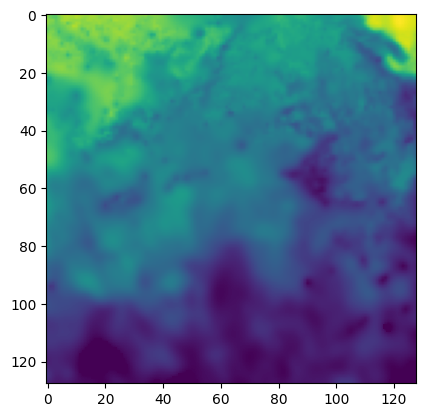

In [106]:
plt.imshow(test[100,:,:,0],vmin=273)

In [121]:
ds = xr.open_dataset('/dat1/smart1n/aviso-data/global training data/SimVP_SSH_SST_1M_global_L250km_mappedSLA_wgrads_20240202_20240430.nc')
ds2 = xr.open_dataset('/dat1/smart1n/aviso-data/global training data/nrt_global_allsat_phy_l4_20240202_20240208.nc')
ds2

<xarray.Dataset> Size: 83MB
Dimensions:    (time: 1, latitude: 720, nv: 2, longitude: 1440)
Coordinates:
  * time       (time) datetime64[ns] 8B 2024-02-02
  * latitude   (latitude) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 6kB -179.9 -179.6 -179.4 ... 179.6 179.9
  * nv         (nv) int32 8B 0 1
Data variables: (12/13)
    crs        int32 4B ...
    lat_bnds   (latitude, nv) float32 6kB ...
    lon_bnds   (longitude, nv) float32 12kB ...
    sla        (time, latitude, longitude) float64 8MB ...
    err_sla    (time, latitude, longitude) float64 8MB ...
    ugosa      (time, latitude, longitude) float64 8MB ...
    ...         ...
    vgosa      (time, latitude, longitude) float64 8MB ...
    err_vgosa  (time, latitude, longitude) float64 8MB ...
    adt        (time, latitude, longitude) float64 8MB ...
    ugos       (time, latitude, longitude) float64 8MB ...
    vgos       (time, latitude, longitude) float64 8MB ...
    flag_ice   (time, latitude, longitude) float64 8MB ...
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Near-Real-Time Level-4 sea ...
    time_coverage_duration:          P1D
    time_coverage_end:               2024-02-02T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2024-02-01T12:00:00Z
    title:                           NRT merged all satellites Global Ocean G...

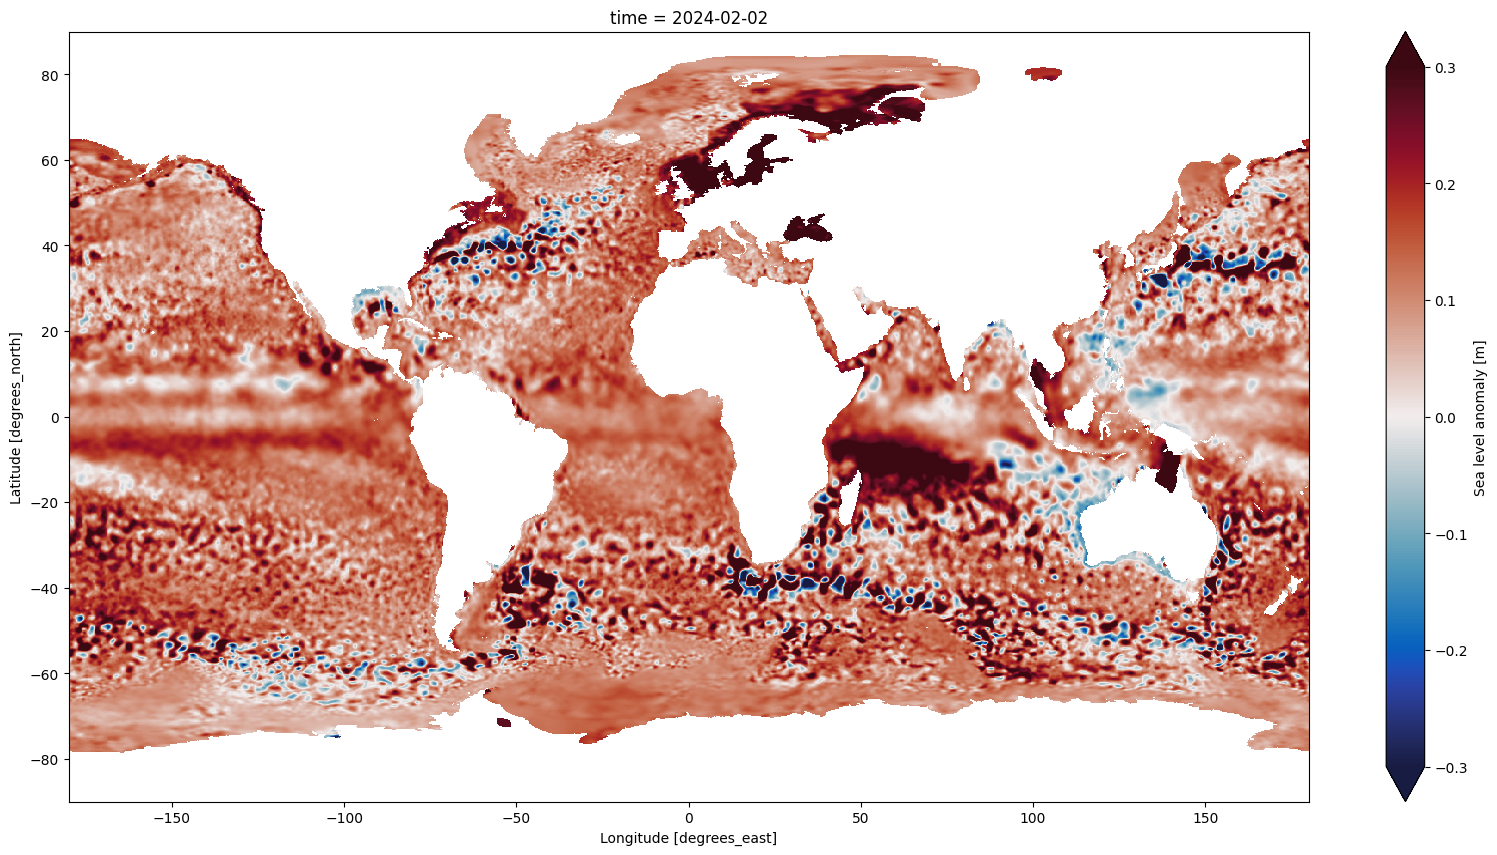

In [122]:
plt.figure(figsize=(20,10))
ds2['sla'].plot(cmap=cmocean.cm.balance,vmin=-0.3,vmax=0.3)

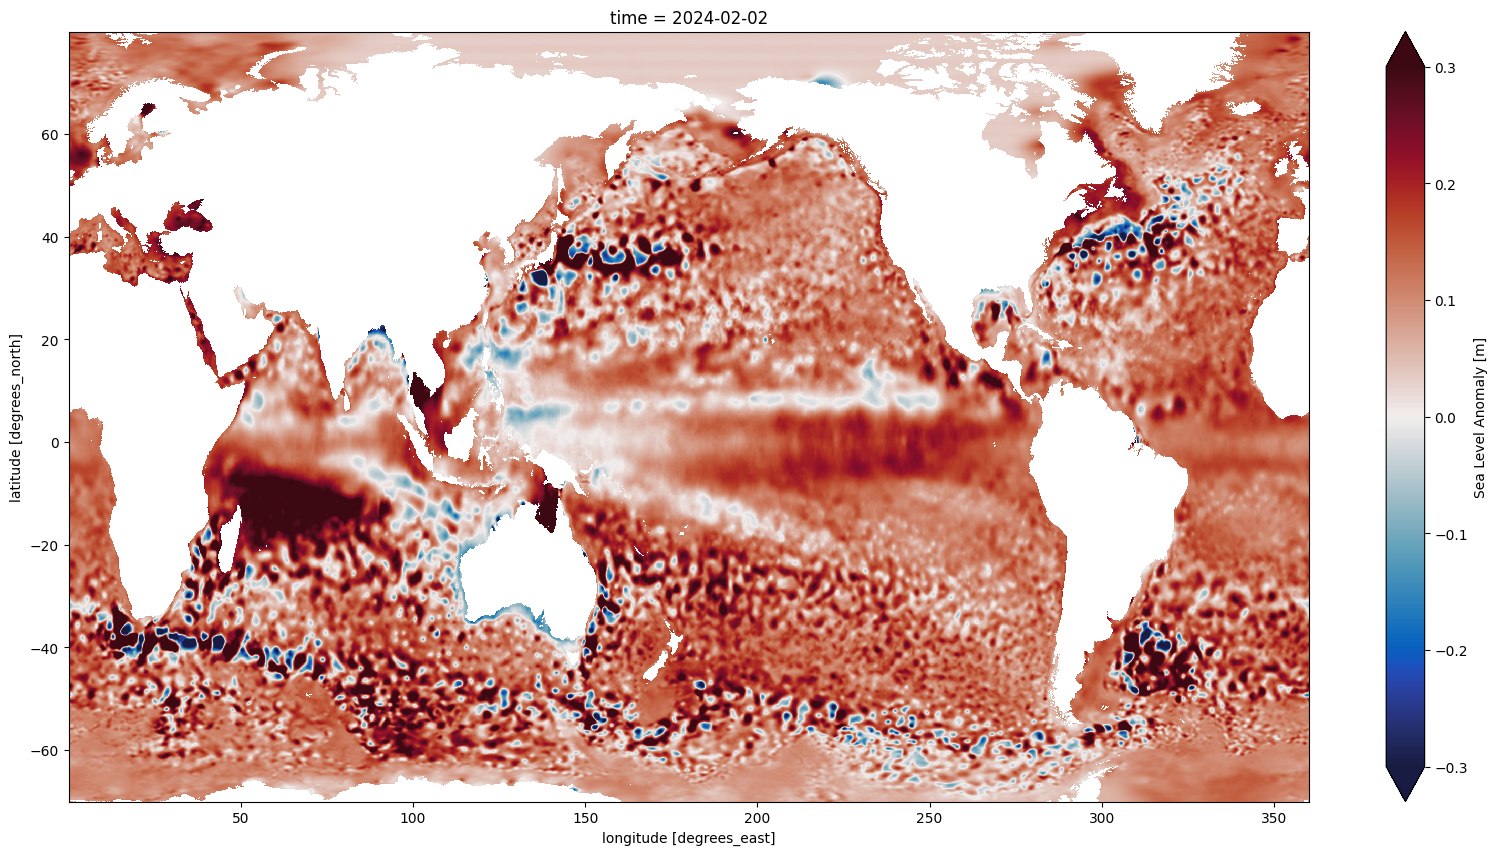

In [120]:
plt.figure(figsize=(20,10))
ds['sla'].plot(cmap=cmocean.cm.balance,vmin=-0.3,vmax=0.3)